In [166]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

# 시각화 옵션
plt.rcParams["figure.dpi"] = 120

# join 기준 데이터
- weather_af_land_2000_2024
    - 4247637 rows
- weather_af_land_forestfiltered_2000_2024
    - 2102696 rows

# 정적 데이터

## population_density (인구밀도)
- Gridded Population of the World(GPW) v4 데이터(2020년 기준)를 사용하여 격자당 인구 수(명/km²)를 고정된 값으로 제공합니다.
- 인구 밀도가 높을수록 인간에 의한 의도적·비의도적 점화 가능성이 커지므로, 화재 점화 위험을 평가하는 데 중요한 변수로 작용합니다.

In [167]:
import pandas as pd
pop_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")
print(pop_df.info())
display(pop_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149290 entries, 0 to 1149289
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   grid_id  1149290 non-null  int64  
 1   value    1149290 non-null  float64
 2   date     1149290 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 26.3+ MB
None


,grid_id,value,date
0,4643451,475.01550,2000-01-01
1,4643451,472.50436,2000-01-01
2,4643452,372.50860,2000-01-01
3,4643452,279.89905,2000-01-01
4,4643452,266.38574,2000-01-01
...,...,...,...
1149285,4431118,82.77728,2020-01-01
1149286,4431119,82.77728,2020-01-01
1149287,4431119,82.77729,2020-01-01
1149288,4431119,82.77729,2020-01-01


공통 grid 수: 581
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 1,426
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 1,426
→ head: [4431089 4431090 4431091 4431092 4431093 4431094 4431095 4431096 4431097
 4431098 4431099 4431100 4431101 4431103 4431104 4431105 4431106 4431107
 4431108 4431109] ...


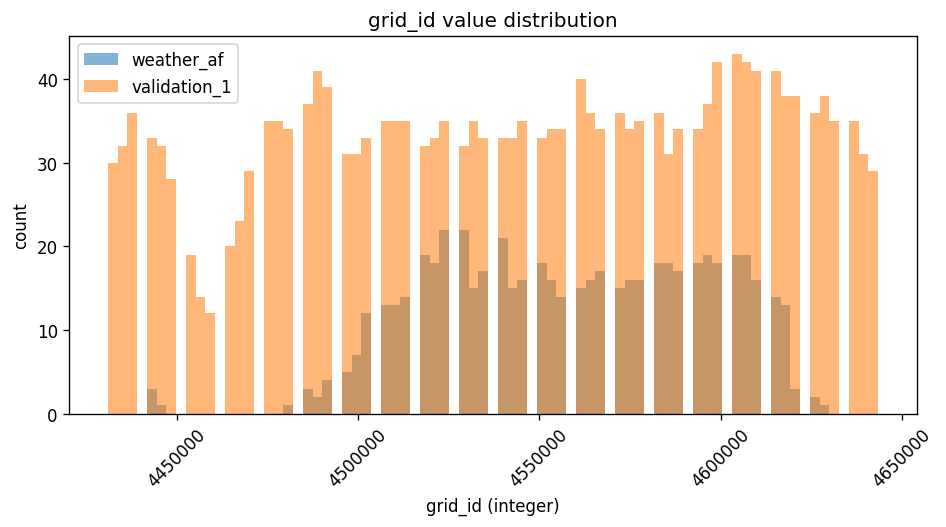

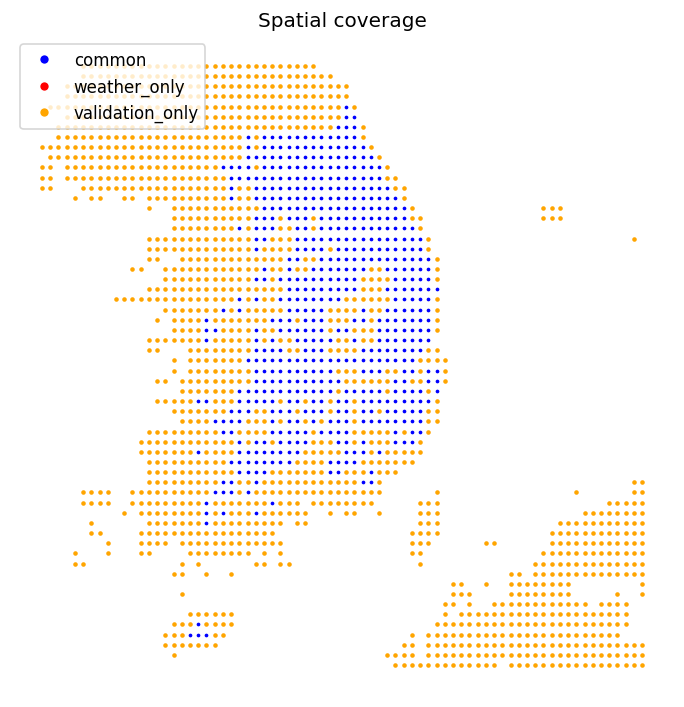

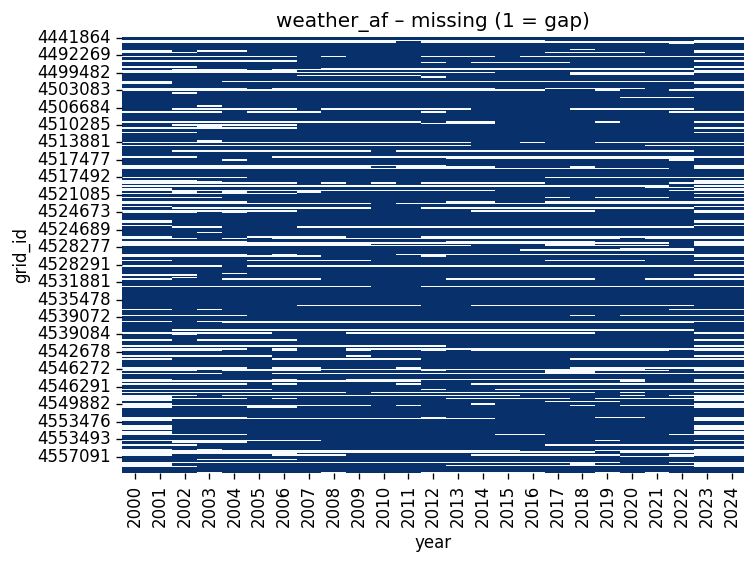

validation_1: no missing cells → heat-map skipped.


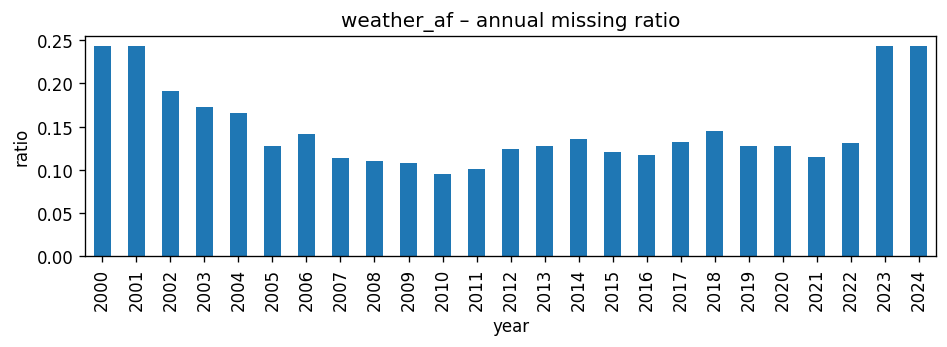

validation_1: no missing years → bar-plot skipped.


In [168]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_2000_2024.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = (row - 900) * 0.1  # 900 오프셋 제거
    lon = (col - 1800) * 0.1  # 1800 오프셋 제거
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")

In [169]:
def temporal_profile(df: pd.DataFrame, label: str) -> None:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])

    uniq_dates = df["date"].drop_duplicates().sort_values()
    start, end = uniq_dates.min(), uniq_dates.max()

    deltas = uniq_dates.diff().dropna()
    deltas = deltas[deltas != pd.Timedelta(0)]     # 0초 차이 제거

    if deltas.empty:
        print(f"[{label}] 고유 날짜 {len(uniq_dates)}개 → 해상도 판별 불가")
        return

    print(f"[{label}] {start.date()} → {end.date()} | 고유 날짜 {len(uniq_dates):,}개")
    print("  · 최빈 간격:", deltas.mode()[0])
    print("  · 최소 간격:", deltas.min())
temporal_profile(weather_af, "weather_af")
temporal_profile(val1, "Validation-1")

[weather_af] 2000-11-02 → 2024-12-31 | 고유 날짜 4,215개
  · 최빈 간격: 1 days 00:00:00
  · 최소 간격: 1 days 00:00:00
[Validation-1] 2000-01-01 → 2020-01-01 | 고유 날짜 5개
  · 최빈 간격: 1826 days 00:00:00
  · 최소 간격: 1826 days 00:00:00


### weather_af_land + pop join

In [170]:
val1['date'] = val1['date'].astype('datetime64[ns]')
val1['year'] = val1['date'].dt.year
result = val1.loc[val1['year']==2020, 'grid_id'].nunique()
print(result)
check = val1.loc[(val1['year']==2020) & (val1['grid_id']==4431090), ]
print(check)

2007
         grid_id     value       date  year
1139708  4431090  92.09882 2020-01-01  2020
1139896  4431090  92.09882 2020-01-01  2020
1140084  4431090  92.09882 2020-01-01  2020
1140085  4431090  92.09882 2020-01-01  2020
1140086  4431090  92.09882 2020-01-01  2020
...          ...       ...        ...   ...
1141856  4431090  92.09882 2020-01-01  2020
1141857  4431090  92.09882 2020-01-01  2020
1141858  4431090  92.09883 2020-01-01  2020
1141859  4431090  92.09882 2020-01-01  2020
1141860  4431090  92.09882 2020-01-01  2020

[69 rows x 4 columns]


grid_id별 다량의 중복데이터 확인

In [171]:
import pandas as pd

# 0) 파일 경로 (필요하다면 수정)
p_pop = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet"

# 1) 인구 데이터 로드
pop = pd.read_parquet(p_pop)

# 2) date → datetime 변환 & 연도 추출
pop["date"] = pd.to_datetime(pop["date"], errors="coerce")
pop["year"] = pop["date"].dt.year

# 3) 2020년 데이터만 필터
pop_2020 = pop[pop["year"] == 2020].copy()
print("▶ Total rows in pop_2020 :", len(pop_2020))

# 4) grid_id별 행 수 집계
counts = pop_2020.groupby("grid_id").size().reset_index(name="count")

# 5) 1개 초과인 grid_id만 골라보기
multi = counts[counts["count"] > 1].copy()
print(f"▶ Number of grid_id with >1 rows in 2020: {len(multi):,}\n")

# 6) 몇 개만 샘플 출력
print("▶ Sample of grid_id having multiple rows:")
print(multi.sort_values("count", ascending=False).head(10))

# 7) (옵션) 가장 많은 중복이 몇 건인지 확인
max_dup = multi["count"].max() if not multi.empty else 1
print(f"\n▶ Maximum number of rows for a single grid_id: {max_dup}")

# 8) (옵션) 중복이 가장 많은 grid_id 몇 개
if max_dup > 1:
    most_dup = multi[multi["count"] == max_dup]["grid_id"].tolist()
    print("▶ grid_id with that maximum duplication:", most_dup[:5], "…")


▶ Total rows in pop_2020 : 229858
▶ Number of grid_id with >1 rows in 2020: 1,990

▶ Sample of grid_id having multiple rows:
      grid_id  count
2004  4643477    144
2003  4643476    144
1986  4643459    144
1985  4643458    144
1984  4643457    144
1983  4643456    144
1982  4643455    144
1981  4643454    144
1980  4643453    144
1979  4643452    144

▶ Maximum number of rows for a single grid_id: 144
▶ grid_id with that maximum duplication: [4431100, 4431105, 4431106, 4431107, 4431108] …


In [172]:
import pandas as pd

# ──────────────────────────────────────────────────────────
# (A) 파일 경로 (필요 시 수정)
# ──────────────────────────────────────────────────────────
p_pop = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet"

# ──────────────────────────────────────────────────────────
# (B) 인구 데이터 로드 후 2020년만 필터링
# ──────────────────────────────────────────────────────────
pop = pd.read_parquet(p_pop, columns=["grid_id", "value", "date"])
pop["date"] = pd.to_datetime(pop["date"], errors="coerce")
pop_2020 = pop[pop["date"].dt.year == 2020].copy()

# ──────────────────────────────────────────────────────────
# (C) 한 번이라도 중복이 있는 grid_id 추출
# ──────────────────────────────────────────────────────────
counts = pop_2020.groupby("grid_id").size().reset_index(name="count")
multi   = counts[counts["count"] > 1]

print(f"▶ 2020년에 2개 이상 행이 있는 grid_id 수: {len(multi):,}")
print("▶ 몇 개 샘플 보기:")
print(multi.head(5))

# ──────────────────────────────────────────────────────────
# (D) 예시로 첫 번째 중복격자(grid_id) 하나를 골라서 내용 출력
# ──────────────────────────────────────────────────────────
if not multi.empty:
    sample_gid = multi["grid_id"].iloc[0]
    print(f"\n>>> Inspecting grid_id = {sample_gid} ({multi.loc[multi['grid_id']==sample_gid, 'count'].iloc[0]} rows) <<<")
    df_gid = pop_2020[pop_2020["grid_id"] == sample_gid].copy()

    # (1) 날짜 분포
    unique_dates = df_gid["date"].unique()
    print("Unique dates for this grid_id:", unique_dates)

    # (2) 날짜별 카운트
    date_counts = df_gid.groupby("date").size().reset_index(name="count")
    print("\nCounts per date:")
    print(date_counts)

    # (3) 값(value) 분포 (최초 10개만)
    print("\nSample rows for this grid_id:")
    print(df_gid.head(10))


▶ 2020년에 2개 이상 행이 있는 grid_id 수: 1,990
▶ 몇 개 샘플 보기:
   grid_id  count
0  4431089      2
1  4431090     69
2  4431091     30
3  4431092     14
4  4431093     10

>>> Inspecting grid_id = 4431089 (2 rows) <<<
Unique dates for this grid_id: <DatetimeArray>
['2020-01-01 00:00:00']
Length: 1, dtype: datetime64[ns]

Counts per date:
        date  count
0 2020-01-01      2

Sample rows for this grid_id:
         grid_id     value       date
1141639  4431089  92.09882 2020-01-01
1141849  4431089  92.09882 2020-01-01


병합 결과 분포:
_merge_pop
both          4247637
left_only           0
right_only          0
Name: count, dtype: int64
▶ pop_mean 결측 행 수: 0


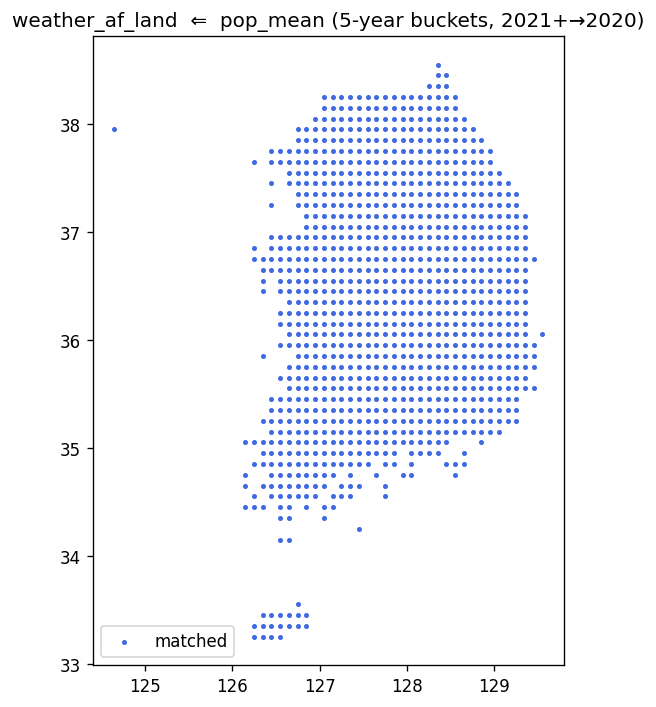

In [175]:
# ──────────────────────────────────────────────────────────
# 0) 라이브러리 & *새* 파일 경로
# ──────────────────────────────────────────────────────────
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ⇩⇩ 사용자가 지정한 최신 경로 ⇩⇩
p_weather = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2000_2024.parquet"
p_pop     = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet"

# ──────────────────────────────────────────────────────────
# 1) 원본 데이터 로드
# ──────────────────────────────────────────────────────────
weather = pd.read_parquet(p_weather)
pop     = pd.read_parquet(p_pop, columns=["grid_id", "value", "date"])

# ──────────────────────────────────────────────────────────
# 2) pop 전처리  ─ anchor_year(2000·2005·…·2020) + 평균
# ──────────────────────────────────────────────────────────
pop["date"] = pd.to_datetime(pop["date"], errors="coerce")
pop["year"] = pop["date"].dt.year

# 5 년 구간 기준 anchor_year 계산 (2000~2020 사이만 유지)
pop["anchor_year"] = (pop["year"] // 5 * 5).clip(lower=2000, upper=2020).astype("int64")

pop_yearly = (
    pop[pop["anchor_year"].between(2000, 2020)]
    .groupby(["grid_id", "anchor_year"], as_index=False)["value"]
    .mean()
    .rename(columns={"value": "pop_mean"})
)

# ──────────────────────────────────────────────────────────
# 3) weather 전처리 ─ anchor_year 계산 & dtype 통일(int64)
# ──────────────────────────────────────────────────────────
weather["date"] = pd.to_datetime(weather["date"], errors="coerce")
weather["year"] = weather["date"].dt.year

weather["anchor_year"] = (
    (weather["year"] // 5 * 5)            # 5-year 버킷
    .clip(lower=2000, upper=2020)         # 2021+ → 2020
    .astype("int64")                      # pop_yearly 와 dtype 맞춤
)

# ──────────────────────────────────────────────────────────
# 4) 병합 (grid_id, anchor_year)
# ──────────────────────────────────────────────────────────
weather_pop = weather.merge(
    pop_yearly,
    on=["grid_id", "anchor_year"],
    how="left",
    indicator="_merge_pop"
)
print("병합 결과 분포:")
print(weather_pop["_merge_pop"].value_counts())

# 필요없는 열 정리
weather_pop = weather_pop.drop(columns=["_merge_pop"])

# ──────────────────────────────────────────────────────────
# 5) (선택) 결측 개수 확인
# ──────────────────────────────────────────────────────────
print("▶ pop_mean 결측 행 수:", weather_pop["pop_mean"].isna().sum())

# ──────────────────────────────────────────────────────────
# 6) (선택) 매칭/누락 지점 시각화
# ──────────────────────────────────────────────────────────
matched_ids = weather_pop.loc[weather_pop["pop_mean"].notna(), "grid_id"].unique()
missing_ids = weather_pop.loc[weather_pop["pop_mean"].isna(),  "grid_id"].unique()

def grid_to_lonlat(gid, nlon=3600):
    row, col = divmod(int(gid), nlon)
    return -180 + 0.1 * (col + 0.5), -90 + 0.1 * (row + 0.5)

gdf_matched = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in matched_ids],
    crs="EPSG:4326"
)
gdf_missing = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in missing_ids],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_matched.empty:
    gdf_matched.plot(ax=ax, color="royalblue", markersize=4, label="matched")
if not gdf_missing.empty:
    gdf_missing.plot(ax=ax, color="crimson",  markersize=4, label="missing")

ax.set_title("weather_af_land  ⇐  pop_mean (5-year buckets, 2021+→2020)")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [165]:
pop['year'].unique()

array([2000, 2005, 2010, 2015, 2020], dtype=int32)

In [192]:
weather_pop.loc[(weather_pop['grid_id']==4571473) & (weather_pop['year']==2010), 'pop_mean']

1442966    228.690454
1443959    228.690454
1444978    228.690454
1445987    228.690454
1446992    228.690454
              ...    
1599136    228.690454
1600151    228.690454
1601146    228.690454
1602165    228.690454
1603172    228.690454
Name: pop_mean, Length: 161, dtype: float64

In [30]:
import pandas as pd
weather_df_nf = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road.parquet")
weather_df_nf

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,lc_type1,pop2020_mean,road_dens_km_km2
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,4.0,279.249435,0.660
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,4.0,36.358682,0.277
2,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,4.0,131.207259,0.333
3,2000-11-02,4571484,36.9,128.5,283.803938,279.473167,-1.007468,-0.959574,7.629395e-07,1.391321,0,4.0,63.913858,0.350
4,2000-11-02,4571483,36.9,128.4,284.193417,279.515823,-0.856358,-0.858679,1.106262e-06,1.212715,0,4.0,27.949960,1.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102691,2024-12-31,4503081,35.0,128.2,275.604777,265.757645,1.162736,-1.858842,0.000000e+00,2.192544,0,5.0,246.636639,0.896
2102692,2024-12-31,4503076,35.0,127.7,274.335392,264.998953,1.717855,-2.163497,0.000000e+00,2.762561,0,4.0,317.078586,0.567
2102693,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,4.0,302.220020,0.465
2102694,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,5.0,256.951853,0.601


In [64]:
weather_af

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,lc_type1
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,4.0
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,4.0
2,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,4.0
3,2000-11-02,4571484,36.9,128.5,283.803938,279.473167,-1.007468,-0.959574,7.629395e-07,1.391321,0,4.0
4,2000-11-02,4571483,36.9,128.4,284.193417,279.515823,-0.856358,-0.858679,1.106262e-06,1.212715,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2102691,2024-12-31,4503081,35.0,128.2,275.604777,265.757645,1.162736,-1.858842,0.000000e+00,2.192544,0,5.0
2102692,2024-12-31,4503076,35.0,127.7,274.335392,264.998953,1.717855,-2.163497,0.000000e+00,2.762561,0,4.0
2102693,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,4.0
2102694,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,5.0


In [65]:
weather_pop

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,lc_type1,pop2020_mean
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,4.0,279.249435
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,4.0,36.358682
2,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,4.0,131.207259
3,2000-11-02,4571484,36.9,128.5,283.803938,279.473167,-1.007468,-0.959574,7.629395e-07,1.391321,0,4.0,63.913858
4,2000-11-02,4571483,36.9,128.4,284.193417,279.515823,-0.856358,-0.858679,1.106262e-06,1.212715,0,4.0,27.949960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102691,2024-12-31,4503081,35.0,128.2,275.604777,265.757645,1.162736,-1.858842,0.000000e+00,2.192544,0,5.0,246.636639
2102692,2024-12-31,4503076,35.0,127.7,274.335392,264.998953,1.717855,-2.163497,0.000000e+00,2.762561,0,4.0,317.078586
2102693,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,4.0,302.220020
2102694,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,5.0,256.951853


## road_density (도로밀도)
- Global Roads Inventory Dataset(2018년)을 통해 계산된 격자당 도로 총 길이(km/km²)를 고정된 값으로 제공합니다.
- 도로는 사람의 접근성을 높여 점화 가능성을 증가시키는 동시에, 소방 장비 진입 경로가 될 수도 있어 화재 예측 모형에서 중요한 입·출입 인프라 변수로 사용됩니다. 

In [193]:
import pandas as pd
road_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")
print(road_df.info())
display(road_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   grid_id           2327 non-null   int64  
 1   road_dens_km_km2  2327 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 36.5 KB
None


,grid_id,road_dens_km_km2
0,4643450,0.000
1,4643451,0.122
2,4643452,0.510
3,4643453,0.392
4,4643454,0.897
...,...,...
2322,4431115,0.375
2323,4431116,0.499
2324,4431117,0.493
2325,4431118,0.437


공통 grid 수: 581
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 1,746
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 1,746
→ head: [4431061 4431062 4431063 4431089 4431090 4431091 4431092 4431093 4431094
 4431095 4431096 4431097 4431098 4431099 4431100 4431101 4431102 4431103
 4431104 4431105] ...


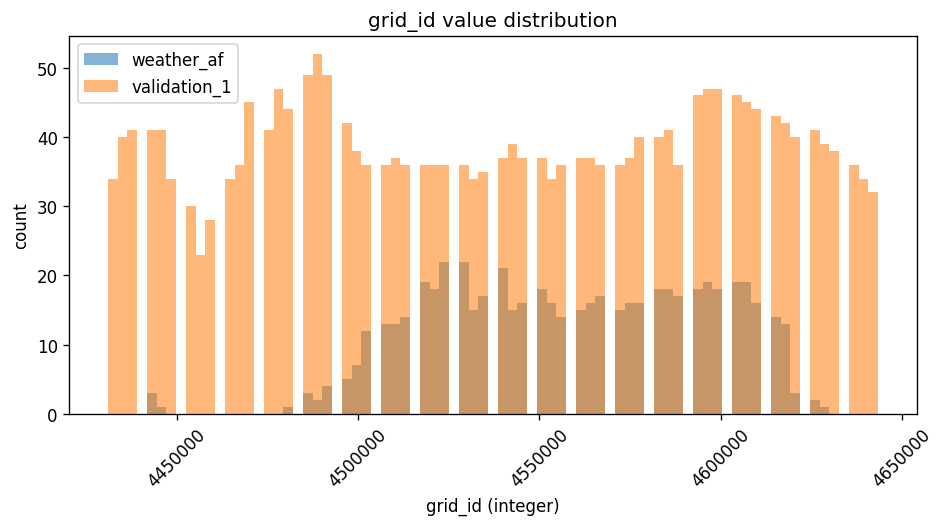

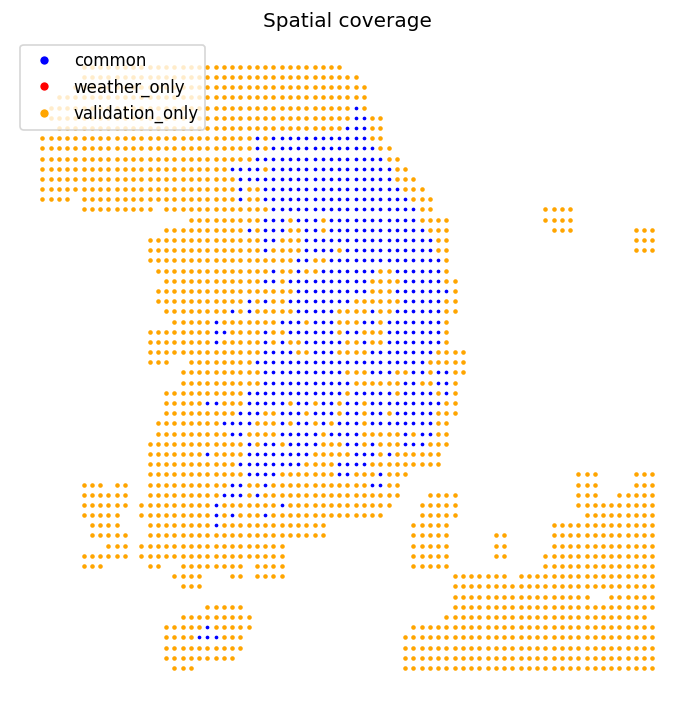

[Skip] validation_1: no date column detected → temporal plots skipped.


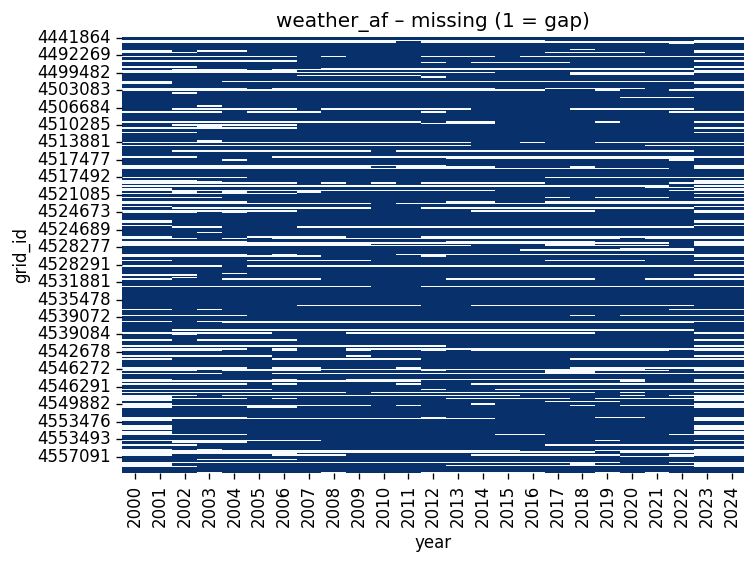

validation_1: no missing cells → heat-map skipped.


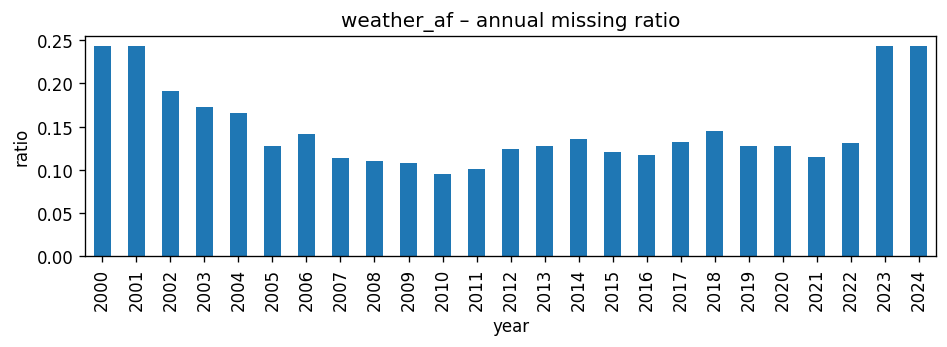

In [68]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_2000_2024.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")



### road join

In [32]:
import pandas as pd

# 1) road_density 데이터 로드
p_road = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet"
road = pd.read_parquet(p_road)

# 2) grid_id별 행 개수 집계
counts = road.groupby("grid_id").size().reset_index(name="count")

# 3) 중복이 있는 grid_id만 필터링
dup = counts[counts["count"] > 1]

# 4) 결과 출력
print(f"Total unique grid_id in road: {road['grid_id'].nunique():,}")
print(f"Total rows in road dataframe : {len(road):,}")
print(f"grid_id with duplicates      : {len(dup):,}")

if not dup.empty:
    print("\nSample duplicated grid_id and their counts:")
    print(dup.head(10))
else:
    print("\nNo duplicate grid_id found in road_density.")


Total unique grid_id in road: 2,327
Total rows in road dataframe : 2,327
grid_id with duplicates      : 0

No duplicate grid_id found in road_density.


Total weather_pop unique grid_id : 1,007
matched grid_id                 : 1,007
missing grid_id                 : 0


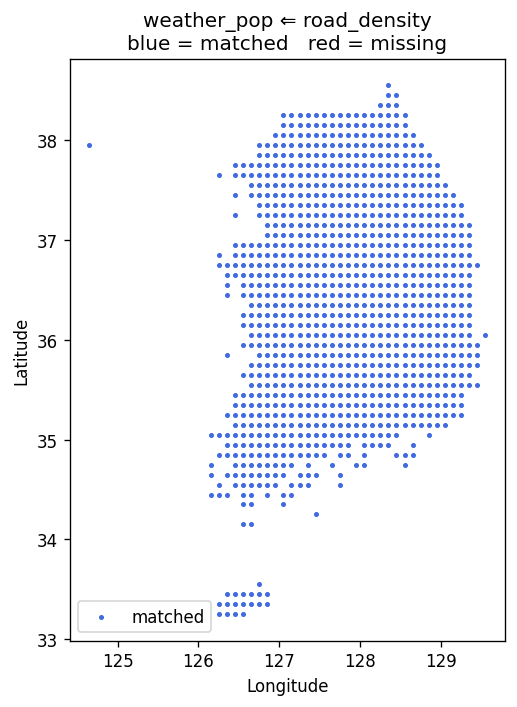

In [194]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────
# 1) road_density 데이터 로드
# ──────────────────────────────────────────────────
p_road = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet"
road = pd.read_parquet(p_road, columns=["grid_id", "road_dens_km_km2"])

# ──────────────────────────────────────────────────
# 2) weather_pop (이미 메모리에 있다 가정)과 단순 JOIN
# ──────────────────────────────────────────────────
# weather_pop: weather_af_land + pop2020_mean 포함된 DataFrame
weather_pop_road = weather_pop.merge(
    road,
    on="grid_id",
    how="left",
    indicator=True
)

# ──────────────────────────────────────────────────
# 3) 매칭/누락 통계
# ──────────────────────────────────────────────────
matched_ids = weather_pop_road.query('_merge == "both"')["grid_id"].unique()
missing_ids = weather_pop_road.query('_merge == "left_only"')["grid_id"].unique()

print(f"Total weather_pop unique grid_id : {weather_pop['grid_id'].nunique():,}")
print(f"matched grid_id                 : {len(matched_ids):,}")
print(f"missing grid_id                 : {len(missing_ids):,}")

# _merge 컬럼 제거
weather_pop_road = weather_pop_road.drop(columns="_merge")

# ──────────────────────────────────────────────────
# 4) grid_to_lonlat 함수 (격자 → lon/lat)
# ──────────────────────────────────────────────────
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    row, col = divmod(int(grid_id), nlon)
    lat = -90 + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

# ──────────────────────────────────────────────────
# 5) 매칭 vs 누락 위치 시각화
# ──────────────────────────────────────────────────
gdf_matched = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in matched_ids],
    crs="EPSG:4326"
)
gdf_missing = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in missing_ids],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_matched.empty:
    gdf_matched.plot(ax=ax, color="royalblue", markersize=4, label="matched")
if not gdf_missing.empty:
    gdf_missing.plot(ax=ax, color="crimson",  markersize=4, label="missing")

ax.set_title("weather_pop ⇐ road_density\nblue = matched   red = missing")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [209]:
weather_pop_road

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601


In [ ]:
# weather_pop_road.drop(columns=['year', 'pop2020_mean', 'road_dens_km_km2_y'])

In [198]:
weather_pop_road.to_parquet("weather_af_land_pop_road.parquet", index=False)

### 인구, 도로밀도 데이터 grid_id 이상 확인

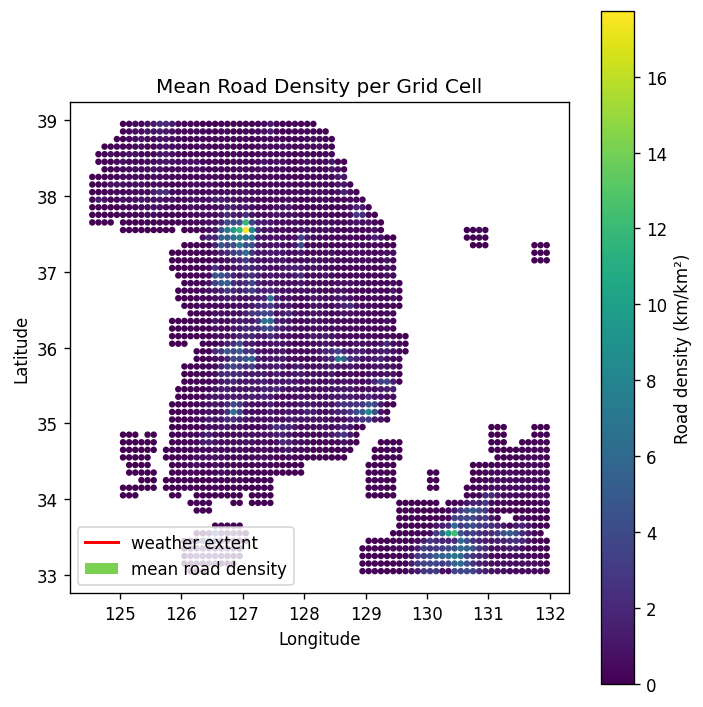

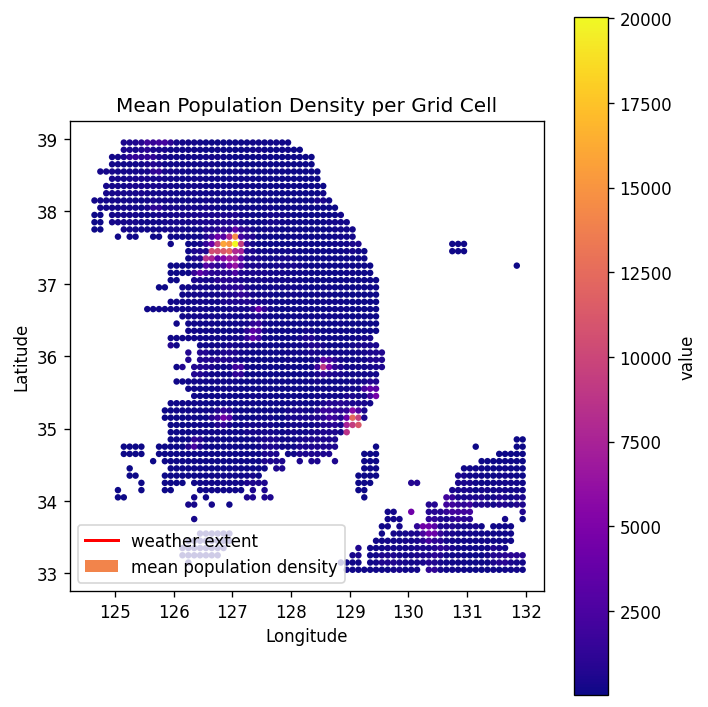

weather grid count : 1,006
road    grid count : 2,327  (outside=1321)
pop     grid count : 2,007  (outside=1001)


In [ ]:
# ======================================================================
# 0. IMPORT & 설정
# ======================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines  import Line2D
from matplotlib.patches import Patch

plt.rcParams["figure.dpi"] = 120   # 노트북/PNG 시각화 품질

# ======================================================================
# 1. 데이터 로드
# ======================================================================
weather = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_2019_2024.parquet")
road = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\road_density\road_density_0.1deg.parquet")
pop = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\population_density\combined_population_density_2000_2020.parquet")

# ======================================================================
# 2. grid_id → (lon, lat) 변환 함수
# ======================================================================
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    """ERA5-Land 0.1° 격자용: 1-D grid_id → 중심 경·위도"""
    row, col = divmod(int(grid_id), nlon)
    lat = -90 + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

# ======================================================================
# 3. weather 격자 외곽선(빨간 실선) 생성 ─ 투영 CRS 사용
# ======================================================================
weather_ids = weather["grid_id"].unique()

# 3-A. Point GeoDataFrame (WGS84)
gdf_w = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in weather_ids],
    crs="EPSG:4326"
)

# 3-B. 한국 지역에 적합한 투영 좌표계(UTM 52N, EPSG:32652)로 변환
gdf_proj = gdf_w.to_crs(32652)

# 3-C. 5 km 버퍼로 셀 간 빈틈 제거 후 union_all → 외곽선 추출
weather_poly   = gdf_proj.buffer(5_000).union_all()
weather_border = gpd.GeoSeries(weather_poly.boundary, crs=32652).to_crs(4326)

# ======================================================================
# 4. road / pop 평균 + 좌표
# ======================================================================
road_mean = (road.groupby("grid_id", as_index=False)["road_dens_km_km2"]
                   .mean())
road_mean[["lon", "lat"]] = road_mean["grid_id"].apply(
    lambda g: pd.Series(grid_to_lonlat(g)))

pop_value_col = [c for c in pop.select_dtypes("number").columns
                 if c != "grid_id"][0]
pop_mean = (pop.groupby("grid_id", as_index=False)[pop_value_col].mean())
pop_mean[["lon", "lat"]] = pop_mean["grid_id"].apply(
    lambda g: pd.Series(grid_to_lonlat(g)))

# ======================================================================
# 5-A. ROAD density 지도 + 빨간 외곽선
# ======================================================================
fig, ax = plt.subplots(figsize=(6, 6))
weather_border.plot(ax=ax, color="none", edgecolor="red", lw=1.8)

sc = ax.scatter(road_mean["lon"], road_mean["lat"],
                c=road_mean["road_dens_km_km2"],
                cmap="viridis", s=15, linewidth=0)

plt.colorbar(sc, label="Road density (km/km²)")
ax.set_title("Mean Road Density per Grid Cell")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

ax.legend(handles=[
    Line2D([0], [0], color="red", lw=1.8, label="weather extent"),
    Patch(facecolor=plt.cm.viridis(0.8), edgecolor="none",
          label="mean road density")
], loc="lower left")
plt.tight_layout(); plt.show()

# ======================================================================
# 5-B. POPULATION density 지도 + 빨간 외곽선
# ======================================================================
fig, ax = plt.subplots(figsize=(6, 6))
weather_border.plot(ax=ax, color="none", edgecolor="red", lw=1.8)

sc2 = ax.scatter(pop_mean["lon"], pop_mean["lat"],
                 c=pop_mean[pop_value_col],
                 cmap="plasma", s=15, linewidth=0)

plt.colorbar(sc2, label=pop_value_col.replace('_', ' '))
ax.set_title("Mean Population Density per Grid Cell")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")

ax.legend(handles=[
    Line2D([0], [0], color="red", lw=1.8, label="weather extent"),
    Patch(facecolor=plt.cm.plasma(0.7), edgecolor="none",
          label="mean population density")
], loc="lower left")
plt.tight_layout(); plt.show()

# ======================================================================
# 6. 수치 검증(road/pop 격자가 weather 범위 밖에 있는지)
# ======================================================================
road_only = np.setdiff1d(road_mean["grid_id"], weather_ids)
pop_only  = np.setdiff1d(pop_mean["grid_id"], weather_ids)

print(f"weather grid count : {len(weather_ids):,}")
print(f"road    grid count : {len(road_mean):,}  (outside={len(road_only)})")
print(f"pop     grid count : {len(pop_mean):,}  (outside={len(pop_only)})")

## Orography (지형)
- 해당 격자의 평균 해발 고도(m) 또는 지형 경사도를 ECLand를 통해 고정된 값으로 제공합니다.
- 고도가 높거나 경사가 가파르면 연료 건조도나 바람 흐름에 영향을 주므로, 화재 발생 가능성과 확산 속도 예측 시 중요합니다. 

In [73]:
import pandas as pd
orography_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Orography\orography_korea_cleaned.csv")
orography_df

,lat,lon,elevation
0,33.0,126.0,0.0
1,33.0,126.1,0.0
2,33.0,126.2,0.0
3,33.0,126.3,0.0
4,33.0,126.4,0.0
...,...,...,...
3685,39.0,128.6,0.0
3686,39.0,128.7,0.0
3687,39.0,128.8,0.0
3688,39.0,128.9,0.0


In [81]:
import pandas as pd
import numpy as np

# 1) 데이터 로드
orography_df = pd.read_csv(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Orography\orography_korea_cleaned.csv"
)
# 4) 결과 확인
print(orography_df.head())

    lat    lon  elevation
0  33.0  126.0        0.0
1  33.0  126.1        0.0
2  33.0  126.2        0.0
3  33.0  126.3        0.0
4  33.0  126.4        0.0


▶ Duplicate grid_id detected in orography_df. Aggregating elevation by mean.

▶ weather unique grid_id               : 581
▶ matched (both) grid_id count         : 281
▶ missing (left_only) grid_id count    : 300


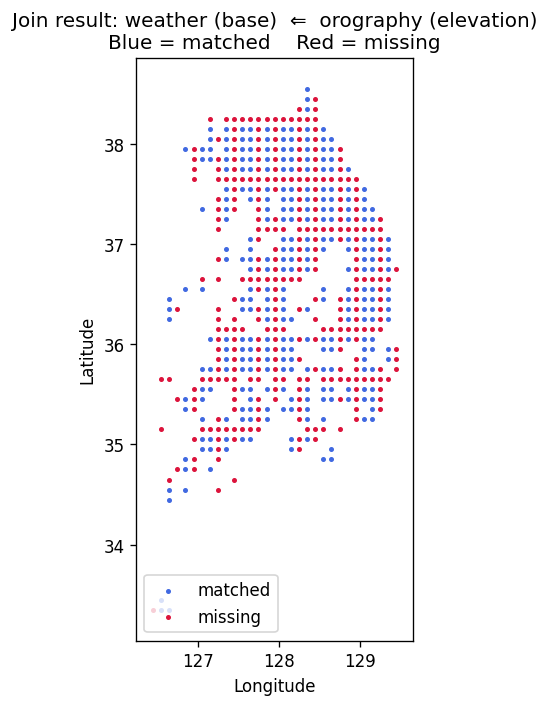

In [84]:
# ======================================================================
# 0. IMPORTS & SETTINGS
# ======================================================================
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120   # High-DPI figures

# ======================================================================
# 1. Helper Functions: grid_id ↔ (lon, lat)
# ======================================================================
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    """
    ERA5-Land 0.1° grid → (longitude, latitude)
    - row = floor(grid_id / nlon)
    - col = grid_id % nlon
    - lat = -90 + 0.1 * (row + 0.5)
    - lon = -180 + 0.1 * (col + 0.5)
    """
    row, col = divmod(int(grid_id), nlon)
    lat = -90.0 + 0.1 * (row + 0.5)
    lon = -180.0 + 0.1 * (col + 0.5)
    return lon, lat

def latlon_to_grid(lat: np.ndarray, lon: np.ndarray, nlon: int = 3600):
    """
    (latitude, longitude) → ERA5-Land 1D grid_id
    - row = floor((lat + 90) / 0.1)
    - col = floor((lon + 180) / 0.1)
    - grid_id = row * nlon + col
    """
    row_idx = np.floor((lat + 90.0) / 0.1).astype(int)
    col_idx = np.floor((lon + 180.0) / 0.1).astype(int)
    return row_idx * nlon + col_idx

# ======================================================================
# 2. Load weather_af_land & build its border outline
# ======================================================================
weather = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road.parquet"
)
weather_ids = weather["grid_id"].unique()

# 2-A. Convert weather_ids → GeoDataFrame of points (WGS84)
gdf_w = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in weather_ids],
    crs="EPSG:4326"
)

# 2-B. Project to UTM 52N (EPSG:32652), buffer 5 km, union, then back to WGS84
gdf_proj      = gdf_w.to_crs(32652)
weather_poly   = gdf_proj.buffer(5_000).union_all()  # 5 km buffer merges close cells
weather_border = gpd.GeoSeries(weather_poly.boundary, crs=32652).to_crs(4326)

# ======================================================================
# 3. Load orography data, compute ERA5‐compatible grid_id, aggregate if needed
# ======================================================================
orog_csv_path = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Orography\orography_korea_cleaned.csv"
orography_df  = pd.read_csv(orog_csv_path)

# 3-A. Compute ERA5 grid_id if not already present
if "grid_id" not in orography_df.columns:
    lat = orography_df["lat"].values
    lon = orography_df["lon"].values
    orography_df["grid_id"] = latlon_to_grid(lat, lon)

# 3-B. Check for duplicate grid_id
counts = orography_df.groupby("grid_id").size().reset_index(name="count")
dup    = counts[counts["count"] > 1]

if not dup.empty:
    print("▶ Duplicate grid_id detected in orography_df. Aggregating elevation by mean.")
    val_agg = (
        orography_df
        .groupby("grid_id", as_index=False)["elevation"]
        .mean()
        .rename(columns={"elevation": "elevation_mean"})
    )
else:
    print("▶ No duplicate grid_id. Using elevation directly.")
    val_agg = orography_df[["grid_id", "elevation"]].rename(
        columns={"elevation": "elevation_mean"}
    )

# ======================================================================
# 4. LEFT JOIN: weather ← orography (on grid_id), then compute matched/missing
# ======================================================================
weather_val = weather.merge(
    val_agg,
    on="grid_id",
    how="left",
    indicator=True
)

matched_ids = weather_val.query('_merge == "both"')["grid_id"].unique()
missing_ids = weather_val.query('_merge == "left_only"')["grid_id"].unique()

print(f"\n▶ weather unique grid_id               : {len(weather_ids):,}")
print(f"▶ matched (both) grid_id count         : {len(matched_ids):,}")
print(f"▶ missing (left_only) grid_id count    : {len(missing_ids):,}")

# Remove the merge indicator column
weather_val = weather_val.drop(columns="_merge")

# ======================================================================
# 5. Visualize matched vs missing grid cells on the map
# ======================================================================
# 5-A. Create GeoDataFrames for matched and missing
gdf_matched = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in matched_ids],
    crs="EPSG:4326"
)
gdf_missing = gpd.GeoDataFrame(
    geometry=[Point(*grid_to_lonlat(g)) for g in missing_ids],
    crs="EPSG:4326"
)

# 5-B. Plot border + matched (blue) + missing (red)
fig, ax = plt.subplots(figsize=(6, 6))
weather_border.plot(ax=ax, color="none", edgecolor="red", lw=1.8)

if not gdf_matched.empty:
    gdf_matched.plot(ax=ax, markersize=4, color="royalblue", label="matched")
if not gdf_missing.empty:
    gdf_missing.plot(ax=ax, markersize=4, color="crimson",  label="missing")

ax.set_title(
    "Join result: weather (base)  ⇐  orography (elevation)\n"
    "Blue = matched    Red = missing"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()

## Urban_Frac (도시 분율)
- 해당 격자(cell) 내에서 도시 지역이 차지하는 비율(0~1)을 ECLand를 통해 고정된 값으로 제공합니다.
- 인위적 불꽃(쓰레기 소각, 난방 등) 발생 가능성과 소화 자원 접근성 등을 간접적으로 반영하여, 인간 인위 점화 확률에 영향을 미칩니다

In [76]:
import pandas as pd
urban_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Urban Frac\urban_frac_korea_cleaned.csv")
print(urban_df.info())
display(urban_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4800 entries, 0 to 4799
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid_id     4800 non-null   int64  
 1   lat         4800 non-null   float64
 2   lon         4800 non-null   float64
 3   urban_frac  4800 non-null   float64
 4   geometry    4800 non-null   object 
dtypes: float64(3), int64(1), object(1)
memory usage: 187.6+ KB
None


,grid_id,lat,lon,urban_frac,geometry
0,1,33.05,124.05,0.0,POINT (124.05 33.05)
1,2,33.05,124.15,0.0,POINT (124.15 33.05)
2,3,33.05,124.25,0.0,POINT (124.25 33.05)
3,4,33.05,124.35,0.0,POINT (124.34999999999998 33.05)
4,5,33.05,124.45,0.0,POINT (124.44999999999996 33.05)
...,...,...,...,...,...
4795,4796,38.95,131.55,0.0,POINT (131.5499999999996 38.95000000000008)
4796,4797,38.95,131.65,0.0,POINT (131.64999999999958 38.95000000000008)
4797,4798,38.95,131.75,0.0,POINT (131.74999999999957 38.95000000000008)
4798,4799,38.95,131.85,0.0,POINT (131.84999999999957 38.95000000000008)


공통 grid 수: 0
검증 데이터에 없는 grid 수: 581
weather_af에 없는 grid 수: 4,800
[weather_af  minus  validation_1] missing count : 581
→ head: [4441864 4441865 4441866 4445465 4481466 4485066 4485068 4485072 4488666
 4488674 4492267 4492268 4492269 4492271 4495868 4495869 4495872 4495885
 4495886 4499470] ...
[validation_1 minus weather_af] missing count   : 4,800
→ head: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] ...


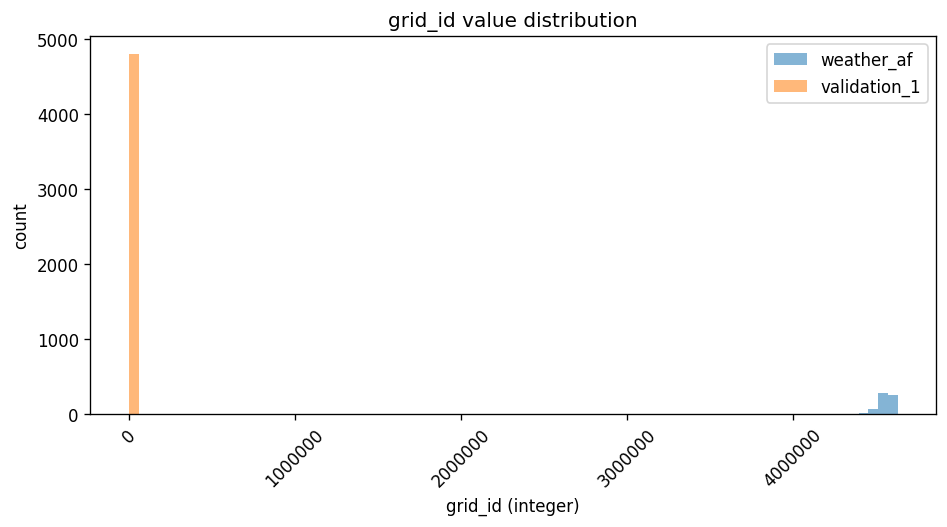

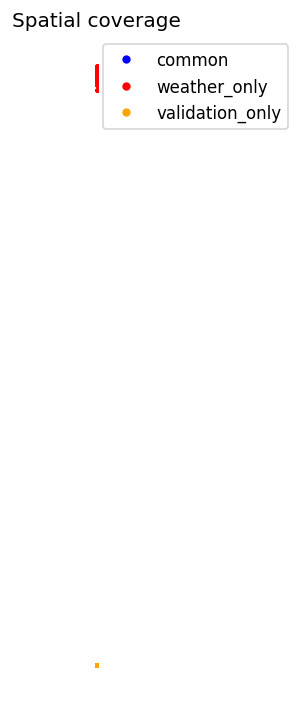

[Skip] validation_1: no date column detected → temporal plots skipped.


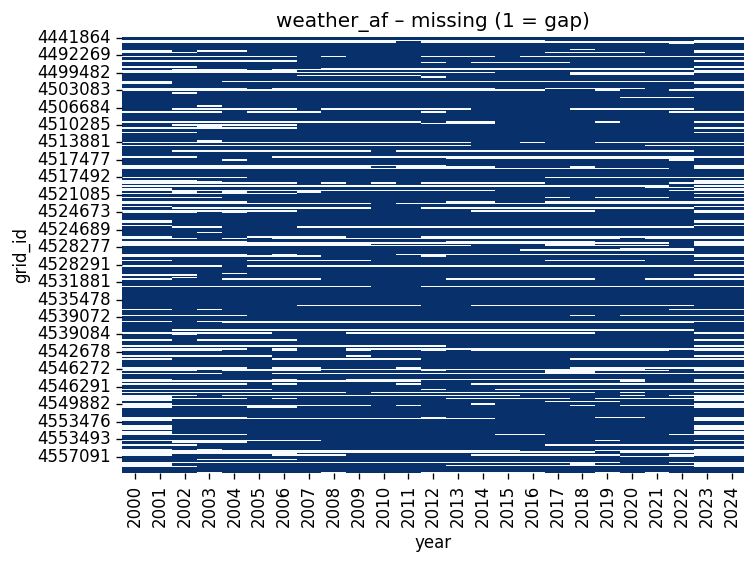

validation_1: no missing cells → heat-map skipped.


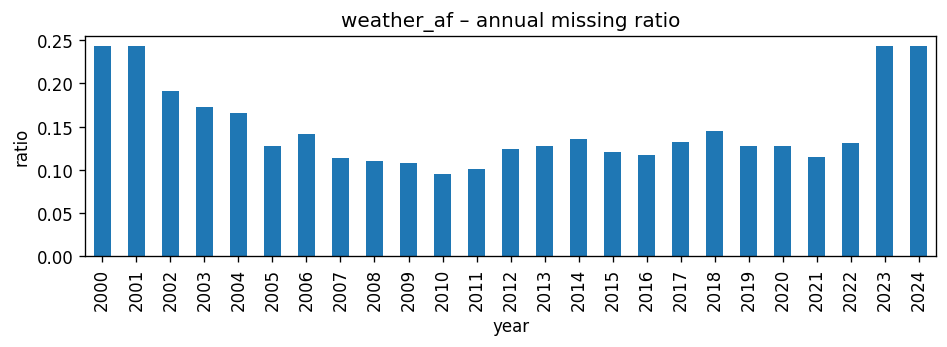

In [88]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road.parquet")
val1 = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Urban Frac\urban_frac_korea_cleaned.csv")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")

In [83]:
import pandas as pd
weather_af1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road.parquet")
weather_af2 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road.parquet")
display(weather_af1.head())
display(weather_af2.head())

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,lc_type1,pop2020_mean,road_dens_km_km2_x,year,pop_mean,road_dens_km_km2_y
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,4.0,279.249435,0.660,2000,189.825201,0.660
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,4.0,36.358682,0.277,2000,59.841866,0.277
2,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,4.0,131.207259,0.333,2000,179.642555,0.333
3,2000-11-02,4571484,36.9,128.5,283.803938,279.473167,-1.007468,-0.959574,7.629395e-07,1.391321,0,4.0,63.913858,0.350,2000,92.817196,0.350
4,2000-11-02,4571483,36.9,128.4,284.193417,279.515823,-0.856358,-0.858679,1.106262e-06,1.212715,0,4.0,27.949960,1.002,2000,46.414750,1.002


,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,pop2020_mean,road_dens_km_km2_x,year,pop_mean,road_dens_km_km2_y
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,279.249435,0.660,2000,189.825201,0.660
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,36.358682,0.277,2000,59.841866,0.277
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,20.983892,0.271,2000,31.760434,0.271
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,99.719231,0.376,2000,137.163520,0.376
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,131.207259,0.333,2000,179.642555,0.333


## Vegetation (식생 유형)
- ECMWF의 Land Surface Model(ECLand)을 통해 고정(Fixed)된 형태로 제공되는 식생 커버 유형(예: 숲, 초지, 농지 등)에 대한 범주형 정보입니다.
- 특정 식생 유형은 화재 확산 특성이 다르므로, 점화 및 연소 특성을 모델에 반영하기 위해 사용됩니다

In [199]:
import pandas as pd
vege_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Vegetation\vegetation_type_korea.csv")
print(vege_df.info())
display(vege_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6220800 entries, 0 to 6220799
Data columns (total 4 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   date             object
 1   grid_id          int64 
 2   lead             int64 
 3   vegetation_type  int64 
dtypes: int64(3), object(1)
memory usage: 189.8+ MB
None


,date,grid_id,lead,vegetation_type
0,2022-01-01,4643440,0,210
1,2022-01-01,4643440,0,210
2,2022-01-01,4643440,0,210
3,2022-01-01,4643440,0,210
4,2022-01-01,4643440,0,210
...,...,...,...,...
6220795,2022-01-01,4431119,0,210
6220796,2022-01-01,4431119,0,210
6220797,2022-01-01,4431119,0,210
6220798,2022-01-01,4431119,0,210


공통 grid 수: 1,007
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 3,793
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 3,793
→ head: [4431040 4431041 4431042 4431043 4431044 4431045 4431046 4431047 4431048
 4431049 4431050 4431051 4431052 4431053 4431054 4431055 4431056 4431057
 4431058 4431059] ...


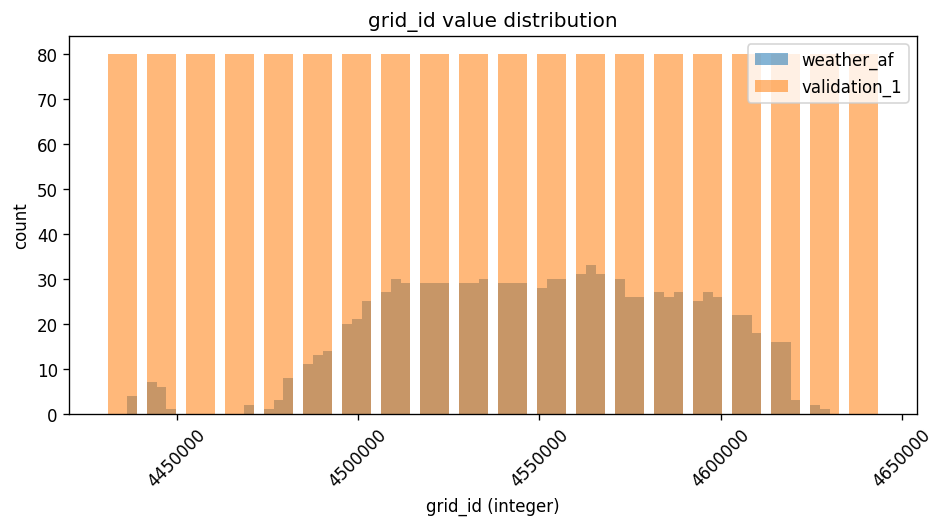

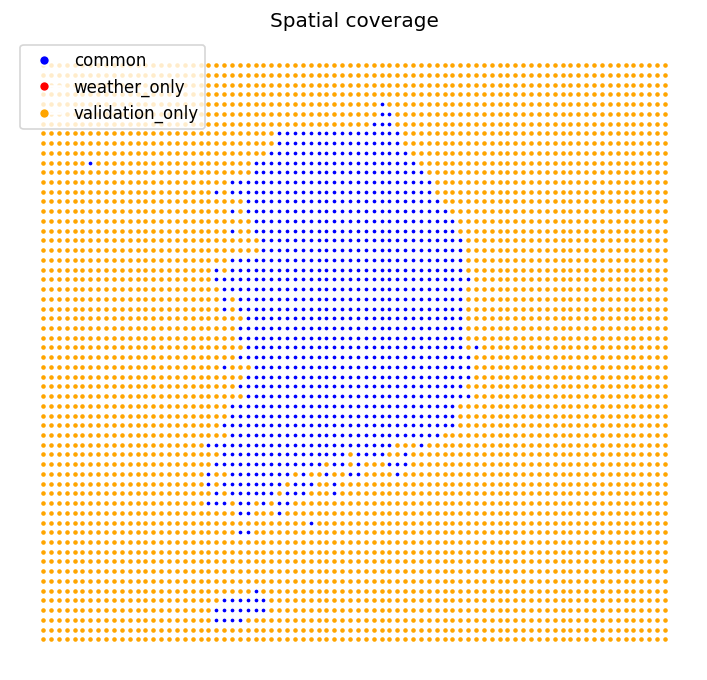

weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.
validation_1: no missing years → bar-plot skipped.


In [200]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road.parquet")
val1 = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\Vegetation\vegetation_type_korea.csv")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")

In [43]:
val1.loc[(val1['date']=='2022-01-01') & (val1['grid_id']==4643440) & (val1['vegetation_type']==210),]

,date,grid_id,lead,vegetation_type
0,2022-01-01,4643440,0,210
1,2022-01-01,4643440,0,210
2,2022-01-01,4643440,0,210
3,2022-01-01,4643440,0,210
4,2022-01-01,4643440,0,210
...,...,...,...,...
100831,2022-01-01,4643440,0,210
100832,2022-01-01,4643440,0,210
100833,2022-01-01,4643440,0,210
100834,2022-01-01,4643440,0,210


In [44]:
val1['grid_id'].nunique()

4800

중복 제거 전 val1 행 수: 6220800
① date∙grid_id∙lead∙vegetation_type 중복 제거 후 행 수: 20763
② grid_id별 하나만 남긴 후 행 수: 4800
Total weather_af unique grid_id      : 1,007
matched grid_id (vegetation 붙음)      : 1,007
missing grid_id (vegetation 없음)       : 0


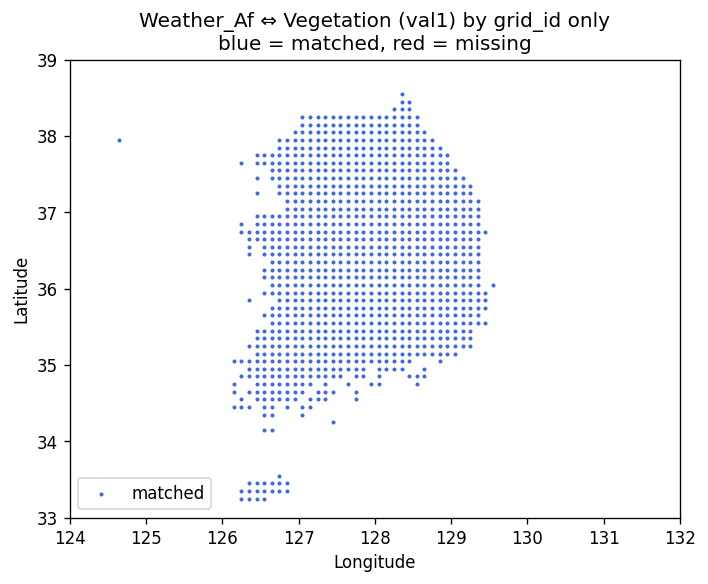

In [201]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) val1에서 중복 제거: grid_id별로 하나의 vegetation_type만 남김
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd

# val1: 원본 vegetation_type_korea 데이터
print("중복 제거 전 val1 행 수:", len(val1))

# (1) date, lead까지 고려해 완전 중복 제거
val1_dedup = val1.drop_duplicates(subset=["date", "grid_id", "lead", "vegetation_type"])
print("① date∙grid_id∙lead∙vegetation_type 중복 제거 후 행 수:", len(val1_dedup))

# (2) grid_id 기준으로 하나만 남기기 (첫 번째 출현을 그대로 사용)
val1_unique = val1_dedup.drop_duplicates(subset=["grid_id"], keep="first")[["grid_id", "vegetation_type"]]
print("② grid_id별 하나만 남긴 후 행 수:", len(val1_unique))


# ──────────────────────────────────────────────────────────────────────────────
# 2) weather_af와 grid_id 기준으로 merge
# ──────────────────────────────────────────────────────────────────────────────
# weather_af: 기상+산림 필터된 데이터 (이미 메모리 로드된 상태)
# val1_unique: grid_id별 vegetation_type 하나씩만 들어 있음

# 메모리 절약을 위해 병합 대상 컬럼(val1_unique)만 선택
weather_with_veg = weather_af.merge(
    val1_unique,
    on="grid_id",
    how="left",
    indicator="_merge_veg"
)

# ──────────────────────────────────────────────────────────────────────────────
# 3) 병합 결과 통계: matched vs missing grid_id
# ──────────────────────────────────────────────────────────────────────────────
matched_ids = weather_with_veg.query('_merge_veg == "both"')["grid_id"].unique()
missing_ids = weather_with_veg.query('_merge_veg == "left_only"')["grid_id"].unique()

print(f"Total weather_af unique grid_id      : {weather_af['grid_id'].nunique():,}")
print(f"matched grid_id (vegetation 붙음)      : {len(matched_ids):,}")
print(f"missing grid_id (vegetation 없음)       : {len(missing_ids):,}")

# _merge_veg 컬럼은 더 이상 필요 없으니 제거
weather_with_veg = weather_with_veg.drop(columns="_merge_veg")


# ──────────────────────────────────────────────────────────────────────────────
# 4) grid_id → (lon, lat) 변환 함수
# ──────────────────────────────────────────────────────────────────────────────
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    """
    grid_id → (longitude, latitude) 변환 (0.1° 격자)
      row = grid_id // nlon
      col = grid_id %  nlon
      latitude  = -90  + 0.1 * (row + 0.5)
      longitude = -180 + 0.1 * (col + 0.5)
    """
    row, col = divmod(int(grid_id), nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat


# ──────────────────────────────────────────────────────────────────────────────
# 5) matched_ids / missing_ids → GeoDataFrame으로 변환
# ──────────────────────────────────────────────────────────────────────────────
import numpy as np
import geopandas as gpd

def ids_to_gdf(ids: np.ndarray, color_name: str, marker_size: float):
    """
    grid_id 배열 → GeoDataFrame
    geometry: Point(longitude, latitude)
    'color' 열은 시각화에서 참조용. 실제 plot 시 color_name 직접 지정해도 무방.
    """
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    return gpd.GeoDataFrame(
        {"color": [color_name] * len(ids)},
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_matched = ids_to_gdf(matched_ids, "royalblue", 2)
gdf_missing = ids_to_gdf(missing_ids, "crimson",   4)


# ──────────────────────────────────────────────────────────────────────────────
# 6) 시각화: matched vs missing 위치 분포
# ──────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 120
fig, ax = plt.subplots(figsize=(6, 6))

# matched: 파란색 점
if not gdf_matched.empty:
    gdf_matched.plot(ax=ax, color="royalblue", markersize=2, label="matched")

# missing: 빨간색 점
if not gdf_missing.empty:
    gdf_missing.plot(ax=ax, color="crimson", markersize=4, label="missing")

ax.set_title("Weather_Af ⇔ Vegetation (val1) by grid_id only\nblue = matched, red = missing")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="lower left")

# 한국 영역 범위 (경도 124–132, 위도 33–39)을 화면에 국한
ax.set_xlim(124, 132)
ax.set_ylim(33, 39)
ax.set_aspect("equal", adjustable="box")

plt.tight_layout()
plt.show()


In [202]:
weather_with_veg

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30


In [203]:
weather_with_veg.to_parquet('weather_af_land_pop_road_vege.parquet', index=False)

# 반 동적 데이터

## lai_low_high_monthly (잎면적지수 - 저관목 LAI & 고관목 LAI)
- 저관목 LAI (Low Vegetation Leaf Area Index)
초본·관목 등 높이가 낮은 식생층의 잎 면적 지수(Leaf Area Index)로, 월별 단위로 제공됩니다. LAI는 단위 면적당 식생 잎의 총 면적을 나타내며, 값이 클수록 해당 격자의 연료(식생량)가 풍부함을 의미합니다. 저관목 LAI는 초지나 관목 지대의 연료량을 파악하여 화재 발생 시 초기 확산 가능성을 평가하는 데 활용됩니다.

- 고관목 LAI (High Vegetation Leaf Area Index)
교목·큰 관목 등 높이가 큰 식생층의 잎 면적 지수로, 월별 단위로 제공합니다. 숲 캐노피와 같은 고층 식생의 연료량을 나타내며, 값이 높으면 화재 시 강도(intensity)가 크고 지속 연소(smoldering)가 길어질 가능성이 큽니다. 고관목 LAI는 숲 지역 전체의 바이오매스 밀도를 간접적으로 파악하여 화재 확산 후 잔류 연소 기간을 예측하는 데 유용합니다.

In [204]:
import pandas as pd
lai_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lai_low_high\lai_low_high_monthly.parquet")
print(lai_df.info())
display(lai_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502064 entries, 0 to 1502063
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   grid_id   1502064 non-null  int64         
 1   date      1502064 non-null  datetime64[ns]
 2   lai_low   1502064 non-null  float64       
 3   lai_high  1502064 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 45.8 MB
None


,grid_id,date,lai_low,lai_high
0,4427439,2000-01-01,0.0,0.0
1,4427439,2000-02-01,0.0,0.0
2,4427439,2000-03-01,0.0,0.0
3,4427439,2000-04-01,0.0,0.0
4,4427439,2000-05-01,0.0,0.0
...,...,...,...,...
1502059,4643519,2024-12-01,0.0,0.0
1502060,4643519,2025-01-01,0.0,0.0
1502061,4643519,2025-02-01,0.0,0.0
1502062,4643519,2025-03-01,0.0,0.0


In [205]:
weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege.parquet")
weather_af

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30


공통 grid 수: 1,007
검증 데이터에 없는 grid 수: 0
weather_af에 없는 grid 수: 3,934
[weather_af  minus  validation_1] missing count : 0
→ head: [] 
[validation_1 minus weather_af] missing count   : 3,934
→ head: [4427439 4427440 4427441 4427442 4427443 4427444 4427445 4427446 4427447
 4427448 4427449 4427450 4427451 4427452 4427453 4427454 4427455 4427456
 4427457 4427458] ...


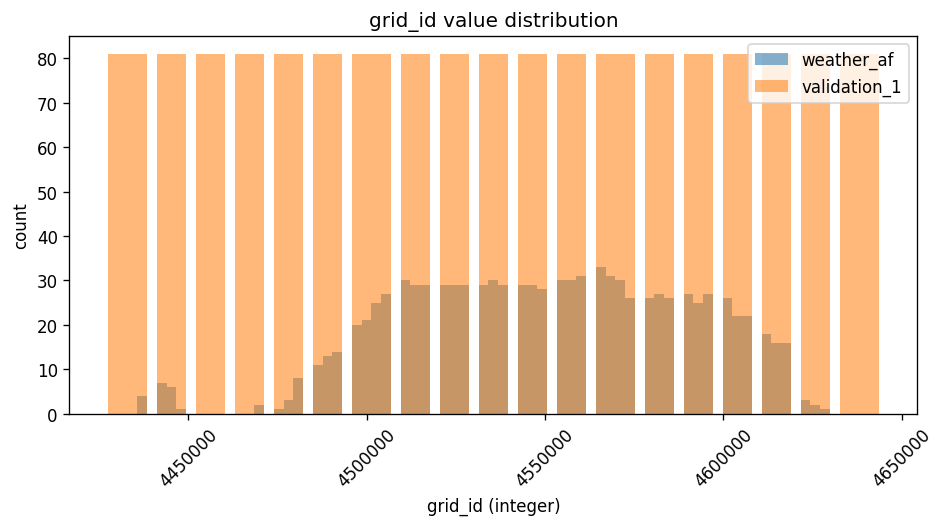

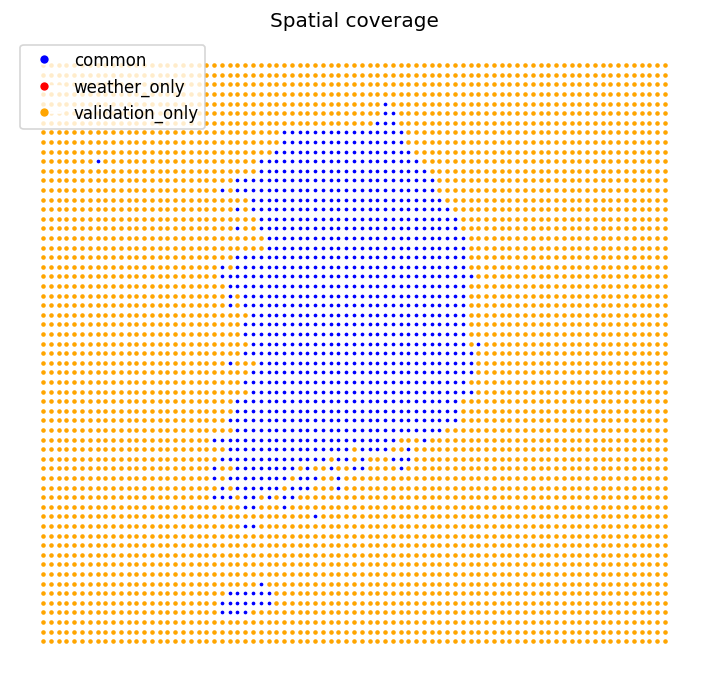

weather_af: no missing cells → heat-map skipped.
validation_1: no missing cells → heat-map skipped.
weather_af: no missing years → bar-plot skipped.
validation_1: no missing years → bar-plot skipped.


In [206]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lai_low_high\lai_low_high_monthly.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")


Common (grid_id, year_month) count: 1,297
Weather-only (missing in LAI): 0
LAI-only (missing in Weather): 3,948
Merge result (_merge_lai) distribution:
_merge_lai
both          4247637
left_only           0
right_only          0
Name: count, dtype: int64
Matched pairs: 292,030
Missing pairs: 0
→ All (grid_id, year_month) combinations have LAI data.


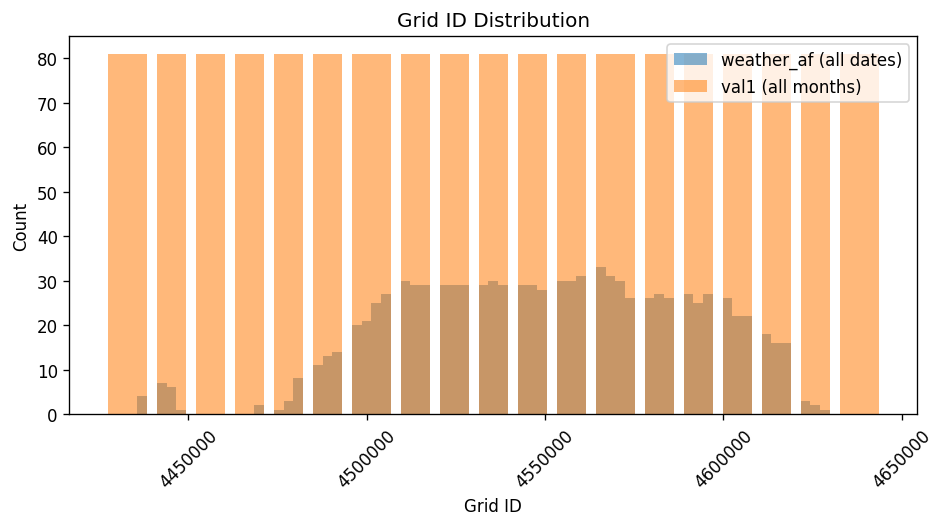

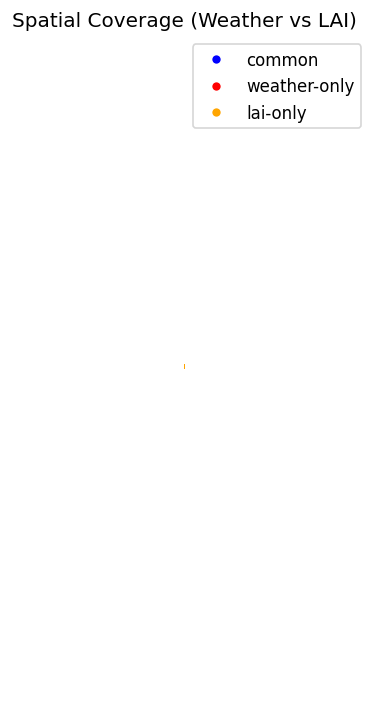

Weather Data Coverage: no missing cells → skip heatmap.
LAI Data Coverage: no missing cells → skip heatmap.
Merged Coverage: no missing cells → skip heatmap.
Weather Data Coverage: no missing years → skip bar plot.
LAI Data Coverage: no missing years → skip bar plot.
Merged Coverage: no missing years → skip bar plot.


In [207]:
# 1) 패키지 임포트 및 데이터 로드
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

weather_af = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege.parquet"
)
val1 = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lai_low_high\lai_low_high_monthly.parquet"
)

# 2) 날짜를 datetime으로 변환하고 'year_month' 컬럼 생성
if "date" in weather_af.columns:
    weather_af["date"] = pd.to_datetime(weather_af["date"], errors="coerce")
elif "time" in weather_af.columns:
    weather_af["date"] = pd.to_datetime(weather_af["time"], errors="coerce")
else:
    raise KeyError("weather_af에 'date' 또는 'time' 컬럼이 필요합니다.")

val1["date"] = pd.to_datetime(val1["date"], errors="coerce")

weather_af["year_month"] = weather_af["date"].dt.to_period("M")
val1["year_month"]     = val1["date"].dt.to_period("M")

# 3) val1에서 grid_id별 대표 월별 데이터만 남기기
lai_cols = [c for c in ["lai_low", "lai_high"] if c in val1.columns]
sel_cols = ["grid_id", "year_month"] + lai_cols

val1_unique = (
    val1
    .drop_duplicates(subset=["grid_id", "year_month"], keep="first")
    .loc[:, sel_cols]
)

# 4) 집합 연산: (grid_id, year_month) 쌍 비교
weather_pairs = (
    weather_af[["grid_id", "year_month"]]
    .drop_duplicates()
    .astype({"grid_id": int})
)
val_pairs = (
    val1_unique[["grid_id", "year_month"]]
    .drop_duplicates()
    .astype({"grid_id": int})
)

weather_pairs["ym_str"] = weather_pairs["year_month"].dt.strftime("%Y-%m")
val_pairs["ym_str"]     = val_pairs["year_month"].dt.strftime("%Y-%m")

weather_tuples = np.array([ (int(g), ys) for g, ys in weather_pairs[["grid_id","ym_str"]].values ])
val_tuples     = np.array([ (int(g), ys) for g, ys in val_pairs[["grid_id","ym_str"]].values   ])

common_pairs             = np.intersect1d(weather_tuples, val_tuples)
missing_in_val1_pairs    = np.setdiff1d(weather_tuples, common_pairs)
missing_in_weather_pairs = np.setdiff1d(val_tuples, common_pairs)

print(f"Common (grid_id, year_month) count: {len(common_pairs):,}")
print(f"Weather-only (missing in LAI): {len(missing_in_val1_pairs):,}")
print(f"LAI-only (missing in Weather): {len(missing_in_weather_pairs):,}")

# 5) 실제 merge: (grid_id, year_month) 기준 Left Join
merge_cols = ["grid_id", "year_month"] + lai_cols

weather_with_lai = weather_af.merge(
    val1_unique.loc[:, merge_cols],
    on=["grid_id", "year_month"],
    how="left",
    indicator="_merge_lai"
)

for col in ["lai_low", "lai_high"]:
    if f"{col}_y" in weather_with_lai.columns:
        weather_with_lai = weather_with_lai.rename(columns={f"{col}_y": col})
    if f"{col}_x" in weather_with_lai.columns:
        weather_with_lai = weather_with_lai.drop(columns=[f"{col}_x"])

print("Merge result (_merge_lai) distribution:")
print(weather_with_lai["_merge_lai"].value_counts())

matched_pairs = (
    weather_with_lai.query('_merge_lai == "both"')
    [["grid_id", "year_month"]]
    .drop_duplicates()
)
missing_pairs = (
    weather_with_lai.query('_merge_lai == "left_only"')
    [["grid_id", "year_month"]]
    .drop_duplicates()
)

print(f"Matched pairs: {len(matched_pairs):,}")
print(f"Missing pairs: {len(missing_pairs):,}")
if len(missing_pairs) == 0:
    print("→ All (grid_id, year_month) combinations have LAI data.")
else:
    print("→ Some (grid_id, year_month) combinations lack LAI data.")

weather_with_lai = weather_with_lai.drop(columns="_merge_lai")

# 6) grid_id 분포 히스토그램 (병합 전후 비교)
weather_ids_all = weather_af["grid_id"].unique()
val_ids_all     = val1_unique["grid_id"].unique()

fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids_all.min(), val_ids_all.min()),
                  max(weather_ids_all.max(), val_ids_all.max()), 80)

ax.hist(weather_ids_all, bins=rng, alpha=0.55, label="weather_af (all dates)")
ax.hist(val_ids_all,     bins=rng, alpha=0.55, label="val1 (all months)")

ax.set_xlabel("Grid ID")
ax.set_ylabel("Count")
ax.set_title("Grid ID Distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 7) Spatial coverage map: common / weather-only / LAI-only
def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    row, col = divmod(int(grid_id), nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def pairs_to_gdf(pairs, color):
    if len(pairs) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    gids = np.array([int(x[0]) for x in pairs])
    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(gids)
    lon, lat = lonlat

    return gpd.GeoDataFrame(
        {"color": [color] * len(gids)},
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

common_arr    = np.array(common_pairs.tolist())
miss_wa_arr   = np.array(missing_in_val1_pairs.tolist())
miss_lai_arr  = np.array(missing_in_weather_pairs.tolist())

gdf_common   = pairs_to_gdf(common_arr,    "blue")
gdf_miss_wa  = pairs_to_gdf(miss_wa_arr,   "red")
gdf_miss_lai = pairs_to_gdf(miss_lai_arr,  "orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:
    gdf_common.plot(ax=ax,    markersize=1.5, color="blue",   label="common")
if not gdf_miss_wa.empty:
    gdf_miss_wa.plot(ax=ax,   markersize=3,   color="red",    label="weather-only")
if not gdf_miss_lai.empty:
    gdf_miss_lai.plot(ax=ax,  markersize=3,   color="orange", label="lai-only")

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label='common',      markerfacecolor='blue',   markersize=6),
    Line2D([0], [0], marker='o', color='w', label='weather-only',markerfacecolor='red',    markersize=6),
    Line2D([0], [0], marker='o', color='w', label='lai-only',     markerfacecolor='orange', markersize=6)
]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial Coverage (Weather vs LAI)")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# 8) Year–grid coverage / missing analysis
def coverage_matrix(df, label, date_candidates=("date", "time", "dt", "datetime")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date/time column, skipping.")
        return None

    df2 = df.copy()
    df2[date_col] = pd.to_datetime(df2[date_col], errors="coerce")
    df2["year"] = df2[date_col].dt.year
    return (
        df2
        .drop_duplicates(["grid_id", "year"])
        .assign(flag=1)
        .pivot(index="grid_id", columns="year", values="flag")
        .fillna(0)
        .astype(int)
    )

cov_w  = coverage_matrix(weather_af, "weather_af")
cov_v1 = coverage_matrix(val1,       "LAI (all months)")
cov_all = coverage_matrix(weather_with_lai, "Merged (weather + LAI)")

def plot_heat(mat, label, sample=300):
    if mat is None or (1 - mat).sum().sum() == 0:
        print(f"{label}: no missing cells → skip heatmap.")
        return
    sns.heatmap(1 - mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("Grid ID"); plt.xlabel("Year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → skip bar plot.")
        return
    gap_rate.plot(kind="bar", figsize=(8, 3), title=f"{label} – annual missing ratio")
    plt.ylabel("Ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "Weather Data Coverage")
plot_heat(cov_v1, "LAI Data Coverage")
plot_heat(cov_all,"Merged Coverage")

plot_gap_ratio(cov_w,  "Weather Data Coverage")
plot_gap_ratio(cov_v1, "LAI Data Coverage")
plot_gap_ratio(cov_all,"Merged Coverage")


In [51]:
weather_with_lai.loc[(weather_with_lai['grid_id']==4571473) & (weather_with_lai['date']=='2022-03-04'),]

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,lc_type1,pop2020_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high
1850782,2022-03-04,4571473,36.9,127.4,281.849973,271.923025,3.604186,2.814943,0.000354,4.573189,0,4.0,279.249435,0.66,11,2022-03,2.664,1.489


In [226]:
pd.set_option('display.max_columns', None)
weather_with_lai

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802


In [227]:
weather_with_lai.to_parquet('weather_af_land_pop_road_vege_lai.parquet')

## LFMC (생 연료 수분 함량)
- 살아 있는 연료(생엽·생목)의 수분 함량(%)을 일일 단위로 제공합니다.
- 수분 함량이 낮을수록 가연성이 높아져 화재 발생 및 확산 가능성이 커지므로, 실시간 연료 건조도를 평가하는 지표로 사용됩니다.

In [212]:
import pandas as pd
lfmc_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\LFMC_combined\LFMC_combined_2011_2021.parquet")
print(lfmc_df.info())
display(lfmc_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11776758 entries, 0 to 11776757
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   time       datetime64[ms]
 1   grid_id    int64         
 2   LFMC       float64       
 3   LFMC_low   float64       
 4   LFMC_high  float64       
dtypes: datetime64[ms](1), float64(3), int64(1)
memory usage: 449.2 MB
None


,time,grid_id,LFMC,LFMC_low,LFMC_high
0,2011-01-01 12:00:00,4643452,110.496376,129.580900,65.408220
1,2011-01-01 12:00:00,4643453,88.165990,132.131260,76.949100
2,2011-01-01 12:00:00,4643453,91.815920,133.785830,85.390180
3,2011-01-01 12:00:00,4643454,94.981810,131.910460,84.208160
4,2011-01-01 12:00:00,4643455,96.728590,126.022610,80.100160
...,...,...,...,...,...
11776753,2021-12-31 12:00:00,4431115,119.770836,110.706116,120.093870
11776754,2021-12-31 12:00:00,4431116,117.708840,110.744600,118.029450
11776755,2021-12-31 12:00:00,4431117,120.417435,123.576650,120.397550
11776756,2021-12-31 12:00:00,4431117,121.795300,123.730250,121.787970


### LFMC Climatology 기반 결측 보간 프로세스

다음은 2000–2024년 기간의 기상 데이터(`weather_af`)에 대해,  
2011–2021년치 LFMC 실측값을 우선 적용하고,  
그 외 구간(2000–2010, 2022–2024)은 격자별·월별 평균(Climatology)으로 채우는 전체 파이프라인입니다.  
아래 코드를 그대로 복사해서 실행하시면 됩니다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11776758 entries, 0 to 11776757
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   time       datetime64[ms]
 1   grid_id    int64         
 2   LFMC       float64       
 3   LFMC_low   float64       
 4   LFMC_high  float64       
dtypes: datetime64[ms](1), float64(3), int64(1)
memory usage: 449.2 MB
None

▶ grid_id = 4431096 에 대한 11월 15일 LFMC 변화 (2011~2021):
           LFMC    LFMC_low   LFMC_high
year                                   
2011  129.98447  110.752014  130.270600
2012  130.07162  110.752914  130.359040
2013  130.19316  110.754036  130.482360
2014  129.24635  110.738890  129.521700
2015  129.83957  110.755010  130.123500
2016  129.37100  110.757614  129.647920
2017  128.96907  110.748030  129.240140
2018  129.12892  110.753230  129.402300
2019  127.64377  110.739110  127.895260
2020  127.89108  110.743380  128.146200
2021  127.55972  110.736560  127.810005

▶ 2011~2021년 매년 1

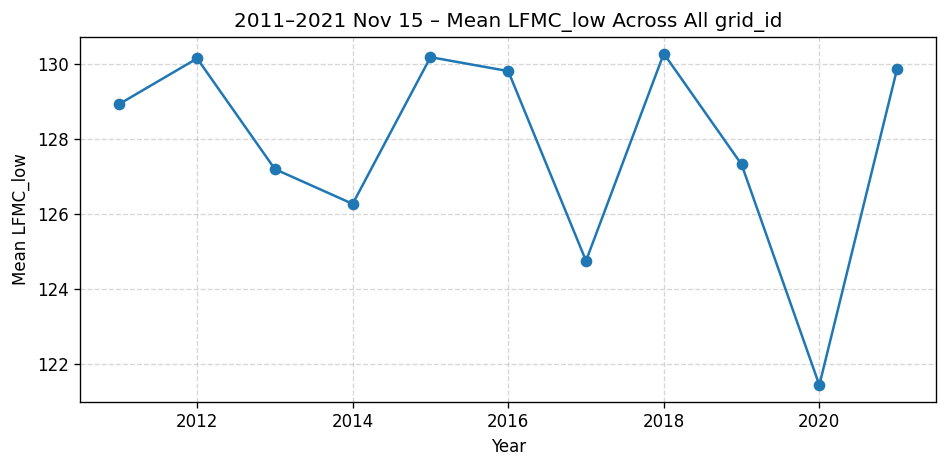

In [213]:
import pandas as pd
import numpy as np

# 1) LFMC 데이터 로드
lfmc_df = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\LFMC_combined\LFMC_combined_2011_2021.parquet"
)

# 데이터 구조 확인
print(lfmc_df.info())
# display(lfmc_df)  # (너무 크면 생략해도 됩니다)

# 2) 'time' 컬럼을 datetime으로 변환하고 연, 월, 일을 추출
lfmc_df["time"] = pd.to_datetime(lfmc_df["time"], errors="coerce")
lfmc_df["year"]  = lfmc_df["time"].dt.year
lfmc_df["month"] = lfmc_df["time"].dt.month
lfmc_df["day"]   = lfmc_df["time"].dt.day

# 3) 예시: “11월 15일”에 해당하는 행만 필터 (2011~2021)
mask_nov15 = (lfmc_df["month"] == 11) & (lfmc_df["day"] == 15)
lfmc_nov15 = lfmc_df[mask_nov15].copy()

# 4) (grid_id, year) 당 하나의 대표값만 남기기
#    (보통 LFMC_df에는 (grid_id, 같은 날짜) 조합이 중복 없다고 가정)
#    혹시 중복이 있다면, keep="first" 로 하나만 남깁니다.
lfmc_nov15_unique = (
    lfmc_nov15
    .drop_duplicates(subset=["grid_id", "year"], keep="first")
    .loc[:, ["grid_id", "year", "LFMC", "LFMC_low", "LFMC_high"]]
)

# 5) 특정 grid_id 예시 한 개(또는 몇 개)를 골라서 연도별 변화 확인
#    여기서는 예시로 가장 작은 grid_id 하나를 사용합니다.
sample_grid = lfmc_nov15_unique["grid_id"].min()

sample_series = (
    lfmc_nov15_unique[lfmc_nov15_unique["grid_id"] == sample_grid]
    .set_index("year")[["LFMC", "LFMC_low", "LFMC_high"]]
    .reindex(range(2011, 2022))  # 2011~2021년까지 모두 표시 (없는 해는 NaN)
)

print(f"\n▶ grid_id = {sample_grid} 에 대한 11월 15일 LFMC 변화 (2011~2021):")
print(sample_series)

# 6) 전체 grid_id 차원에서 “2011~2021년 11월 15일 LFMC_low 평균” 변화
annual_mean = (
    lfmc_nov15_unique
    .groupby("year")["LFMC_low"]
    .mean()
    .reindex(range(2011, 2022))
)

print("\n▶ 2011~2021년 매년 11월 15일 전 지역 LFMC_low 평균:")
print(annual_mean)

# (원하면 바로 차트를 그릴 수도 있습니다)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(annual_mean.index, annual_mean.values, marker="o")
plt.title("2011–2021 Nov 15 – Mean LFMC_low Across All grid_id")
plt.xlabel("Year")
plt.ylabel("Mean LFMC_low")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [214]:
lfmc_df['time'].astype('datetime64[ns]')
lfmc_df.loc[lfmc_df['time']=='2021-06-01 12:00:00', 'grid_id'].nunique()

1497

In [229]:
weather_af = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai.parquet"
)
weather_af.isna().sum()

date                0
grid_id             0
latitude            0
longitude           0
t2m                 0
td2m                0
10u                 0
10v                 0
tp                  0
wind10m             0
af_flag             0
year                0
anchor_year         0
pop_mean            0
road_dens_km_km2    0
vegetation_type     0
year_month          0
lai_low             0
lai_high            0
dtype: int64

### 결측치 발견

★ Climatology 로 채워지지 않은 (grid_id, month) 쌍 : 576 개
     grid_id  month
136  4589464     11
137  4589466     11
184  4582267     11
185  4582264     11
279  4539095     11

▼ month 별 누락 건수
month
1     48
2     48
3     48
4     48
5     48
6     48
7     48
8     48
9     48
10    48
11    48
12    48
Name: count, dtype: int64


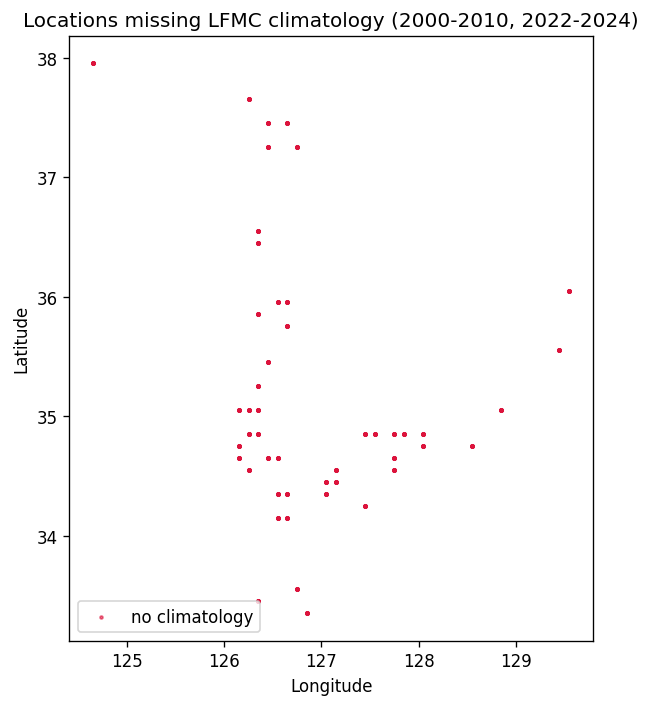

In [233]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# ──────────────────────────────
# 1) Climatology 미매칭 (left_only) 행만 추출
# ──────────────────────────────
missing_clim = (
    weather_with_lfmc_raw            # _merge_clim 이 생기기 전 DataFrame
    .merge(
        clim[["grid_id", "month"]],   # (grid_id, month) 만 갖고 와서
        on=["grid_id", "month"],
        how="left",
        indicator=True
    )
    .query('_merge == "left_only"')[["grid_id", "month"]]
    .drop_duplicates()
)

print(f"★ Climatology 로 채워지지 않은 (grid_id, month) 쌍 : {len(missing_clim):,} 개")
print(missing_clim.head())

# ──────────────────────────────
# 2) 어느 달(month)이 특히 많이 빠졌는지?
# ──────────────────────────────
print("\n▼ month 별 누락 건수")
print(missing_clim["month"].value_counts().sort_index())

# ──────────────────────────────
# 3) 지도에 찍어 보기
# ──────────────────────────────
def grid2lonlat(gid: int, nlon: int = 3600):
    row, col = divmod(int(gid), nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

gdf_missing = gpd.GeoDataFrame(
    missing_clim,
    geometry=[Point(*grid2lonlat(g)) for g in missing_clim["grid_id"]],
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(7, 6))
gdf_missing.plot(
    ax=ax, markersize=3, color="crimson", alpha=0.6,
    label="no climatology"
)
ax.set_title("Locations missing LFMC climatology (2000-2010, 2022-2024)")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


### LFMC 데이터 합치고 결측치 메우는 과정

1. **파일 읽기**  
   * weather  ➜ `weather_af_land_pop_road_vege_lai.parquet`  
   * lfmc     ➜ `LFMC_combined_2011_2021.parquet`

2. **필요한 날짜 컬럼 만들기**  
   * `time`  : 날짜 → `datetime`  
   * `year`, `month` : `time`에서 추출

3. **1차 메우기 – ‘월별 평균값’(Climatology)**  
   * 2011~2021 관측값으로 **(grid_id, month)** 평균표 만든다.  
   * weather-표와 **왼쪽 조인**  
   * 실측이 있으면 살리고, 없으면 위 평균으로 채움  
   * 새 컬럼 → `LFMC_filled`, `LFMC_low_filled`, `LFMC_high_filled`

### 이웃 평균 보간(Manhattan-IDW)

| 단계 | 설명 | 필요성 | 구현 방법 (간략) |
|------|-----------------|----------------|------------------|
| **1. 1차 채우기** | ① **실측 값**이 있으면 그대로 둡니다.<br>② 없다면, 같은 `grid_id` + **같은 달**(예: 모든 6월)의 **2011-2021 평균값**(클라이마토지)으로 채웁니다. | 2011-2021 기간은 위성·관측 자료가 비교적 풍부하므로, 그 평균을 “기본값”으로 사용합니다. | - `pandas.DataFrame.merge()`를 이용하여<br>  - (`grid_id`, `time`) 기준으로 실측 LFMC/DFMC를 먼저 붙이고  
  - (`grid_id`, `month`) 기준으로 Climatology(2011-2021 평균)를 붙임  
- `.fillna()` 메서드로 실측이 없을 때만 클라이마토지 값 사용 |
| **2. 빈칸(NaN) 찾기** | 1차 채움 후에도 아직 값이 없는 셀(격자×월)을 모두 모읍니다. | 관측이 전혀 없는 지역, 혹은 데이터가 부족한 지역입니다. | - `mask = df["LFMC_filled"].isna()` 처럼 불린 마스크를 만들고  
  - `df_nan = df[mask]` 로 남은 NaN 행을 별도 DataFrame으로 저장 |
| **3. 반경 r 설정** | **택시 거리(Manhattan distance)** 반경을 `r = 1 → 3 → 5 → … → 21` 순서로 늘려갑니다. | 가까운 곳부터 살펴보다가, 데이터가 없으면 조금 더 먼 이웃까지 확대하기 위함입니다. | - 거리 단계 `for r in range(1, 22, 2):`  
  - 예시: `r` = 1, 3, 5, … , 21 |
| **4. 이웃 격자 수집** | 대상 격자 `(row, col)` 주변에서 조건 `|dr| + |dc| ≤ r` 를 만족하는 모든 이웃 위치를 찾습니다. | 맨해튼 거리 규칙에 따라 “한 칸 위” 혹은 “두 칸 오른쪽” 등, 여러 칸을 모두 포함합니다. | - 대상격자의 `row = grid_id // nlon`, `col = grid_id % nlon` 계산  
  \`\`\`python
  base_row, base_col = grid_to_rowcol(grid_id)
  neighbors = []
  for dr in range(-r, r+1):
     for dc in range(-r, r+1):
       if abs(dr) + abs(dc) <= r:
          nbr_row = base_row + dr
          nbr_col = base_col + dc
          nbr_gid = nbr_row * nlon + nbr_col
          neighbors.append(nbr_gid)
  \`\`\`  
  - 벡터화: NumPy \`np.add.outer()\` 등으로 배열화하여 속도를 높일 수도 있음 |
| **5. 거리 가중치 계산** | 이웃까지 거리 **d = |dr| + |dc|** 을 구해, **가중치 w = 1 / d** 로 설정합니다. | 가까운 이웃일수록 더 큰 영향을 주기 위함입니다. | - 이미 \`dr\`, \`dc\` 를 알 수 있으므로 거리 \`d = abs(dr) + abs(dc)\`  
  - 가중치 배열 \`weights = 1.0 / distances\`<br>  (거리 \`d\`가 0인 경우(즉, 자기 자신)는 1차 채움 단계에서 이미 값이 채워졌으므로 제외) |
| **6. 가중 평균 계산** | 반경 \`r\` 안에서 **실측 또는 1차 채움(클라이마토지)이 있는** 이웃만 골라서<br>  \`보간값 = Σ(w × val) ÷ Σw\` 로 계산합니다. | 여러 이웃이 모여 있으면 평균값이 안정되고, 가까운 이웃에 더 큰 무게를 두므로 보정이 자연스럽습니다. | - 파이썬 코드 예시:  
  \`\`\`python
  valid_vals = []
  valid_weights = []
  for nbr_gid, d in zip(neighbors, distances):
     val = filled_dict.get(nbr_gid)  # 1차 채움된 값(실측 혹은 클라이마토지)
     if val is not None:
       w = 1.0 / d
       valid_vals.append(val * w)
       valid_weights.append(w)
  if valid_weights:
      interpolated = sum(valid_vals) / sum(valid_weights)
  else:
      interpolated = np.nan
  \`\`\`  
  - \`filled_dict\` 혹은 \`pandas.Series\`를 딕셔너리처럼 사용하여<br>  주변 격자의 1차 채움 값을 빠르게 조회 |
| **7. 채우기 & 확대 반복** | 계산된 보간값이 있으면 해당 셀을 확정합니다.  
  아직 NaN이면 반경을 **r + 2**로 넓혀 다시 시도합니다. \`r = 21\`까지 반복 후에도 값이 없으면 그대로 둡니다. | 관측이나 평균이 전혀 없는 외진 격자가 있어 전체 데이터를 지나치게 왜곡하지 않도록 보호합니다. | - \`for r in range(1, 22, 2): ... if not np.isnan(interpolated): assign & break\` 로 구현  |
| **8. 최종 상태** | 대부분의 격자는 **실측 → 클라이마토지 → 이웃평균** 순으로 값이 채워집니다.  
  여전히 NaN인 셀은 극단적 외딴 격자이므로, 머신러닝 단계에서 제외하거나 전체 평균으로 후처리할 수 있습니다. | 빠진 격자가 최소화되어 모델 학습 시 **데이터 손실을 크게 줄이고**, 예측 정확도를 높입니다. | - \`df_final["LFMC_filled"]\` 에 NaN이 남았다면, <br>  \`df_final.dropna(subset=["LFMC_filled"])\` 혹은<br>  \`df_final["LFMC_filled"].fillna(global_mean)\` 등을 최종 선택 |

---

##### 보간법 구현 요약
1. **1차 채움**: \`pandas.merge()\` + \`.fillna()\`  
2. **반복문으로 이웃 찾기**: 중첩  
    \`for dr in range(-r, r+1): for dc in range(-r, r+1): if |dr|+|dc|≤r\`  
3. **가중치 계산**: 거리 \`d = |dr| + |dc|\`, 가중치 \`w = 1/d\`  
4. **가중 평균**: \`Σ(w·값) / Σw\`  
5. **반경 확대**: \`for r in [1, 3, 5, …, 21]:\` 반복

> **참고**  
> - Manhattan-IDW 보간법은 “격자 상에서 왕이 직선으로 움직일 때의 칸수”를 거리로 쓰며, <br>  “거리의 역수”를 가중치로 두는 고전적인 공법입니다.  
> - 이웃이 멀어질수록 영향력이 약해지므로, 멀리 퍼지는 데이터 왜곡을 방지할 수 있습니다.


In [246]:
# ─────────────────────────────────────────────────────────────
# 0) 패키지 임포트 & 전역 상수
# ─────────────────────────────────────────────────────────────
import pandas as pd, numpy as np
from itertools import product

# 0-1) 파일 경로
P_WEATHER = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai.parquet"
P_LFMC    = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\LFMC_combined\LFMC_combined_2011_2021.parquet"

# 0-2) 격자·보간 파라미터
N_LON   = 3600      # 0.1° 격자의 경도 칸 수
MAX_RAD = 21        # IDW 최대 반경 (1,3,5,…MAX_RAD)
TAR     = ["LFMC_filled", "LFMC_low_filled", "LFMC_high_filled"]

# ═════════════════════════════════════════════════════════════
# 1) 데이터 로드 & 전처리
# ═════════════════════════════════════════════════════════════
weather = pd.read_parquet(P_WEATHER)
lfmc    = pd.read_parquet(P_LFMC)

weather["time"] = pd.to_datetime(weather["date"], errors="coerce")
lfmc["time"]    = pd.to_datetime(lfmc["time"],   errors="coerce")

weather["year"]  = weather["time"].dt.year
weather["month"] = weather["time"].dt.month
lfmc["year"]     = lfmc["time"].dt.year
lfmc["month"]    = lfmc["time"].dt.month

lfmc_train = lfmc.query("2011 <= year <= 2021").copy()

# ═════════════════════════════════════════════════════════════
# 2) Climatology (grid_id, month) 평균
# ═════════════════════════════════════════════════════════════
clim = (
    lfmc_train
    .groupby(["grid_id", "month"], as_index=False)[["LFMC", "LFMC_low", "LFMC_high"]]
    .mean()
    .rename(columns={
        "LFMC": "LFMC_clim",
        "LFMC_low": "LFMC_low_clim",
        "LFMC_high": "LFMC_high_clim"
    })
)

# ═════════════════════════════════════════════════════════════
# 3) 실측 머지 → Climatology 머지 → 1차 보정
# ═════════════════════════════════════════════════════════════
wf_raw = weather.merge(
    lfmc_train[["grid_id","time","LFMC","LFMC_low","LFMC_high"]],
    on=["grid_id","time"], how="left"
)

wf = wf_raw.merge(clim, on=["grid_id","month"], how="left")

wf["LFMC_filled"]      = wf["LFMC"]     .fillna(wf["LFMC_clim"])
wf["LFMC_low_filled"]  = wf["LFMC_low"] .fillna(wf["LFMC_low_clim"])
wf["LFMC_high_filled"] = wf["LFMC_high"].fillna(wf["LFMC_high_clim"])

wf.drop(columns=[
    "LFMC","LFMC_low","LFMC_high",
    "LFMC_clim","LFMC_low_clim","LFMC_high_clim"
], inplace=True)

print("■ 1차 보정 후 남은 결측:", wf["LFMC_filled"].isna().sum())

# ═════════════════════════════════════════════════════════════
# 4) 남은 셀: 이웃(IDW) 보간
# ═════════════════════════════════════════════════════════════
def build_map(df, col):
    return {(int(g),int(m)):v for g,m,v in df[["grid_id","month",col]].values}

missing = wf.index[wf["LFMC_filled"].isna()]

for rad in range(1, MAX_RAD+1, 2):
    if missing.empty: break
    print(f"▶ IDW 반경 {rad} 처리 …")
    
    mapp = {t: build_map(wf.loc[wf[t].notna()], t) for t in TAR}
    newly = []
    
    for idx in missing:
        row = wf.loc[idx]
        gid, mon = int(row.grid_id), int(row.month)
        r0, c0   = divmod(gid, N_LON)
        
        num = {t:0.0 for t in TAR}; den = 0.0
        for dr, dc in product(range(-rad, rad+1), repeat=2):
            dist = abs(dr)+abs(dc)
            if dist==0 or dist>rad: continue
            nr, nc = r0+dr, c0+dc
            if 0<=nr<1800 and 0<=nc<N_LON:
                ngid = nr*N_LON+nc; key = (ngid, mon)
                if key in mapp[TAR[0]]:
                    w = 1.0/dist; den += w
                    for t in TAR: num[t] += w*mapp[t][key]
        if den:
            for t in TAR: wf.at[idx, t] = num[t]/den
            newly.append(idx)
    
    missing = wf.index[wf["LFMC_filled"].isna()]
    print(f"   → 새로 채움 {len(newly):,}, 남은 {len(missing):,}")

print("★ 보간 완료. 최종 결측:", wf["LFMC_filled"].isna().sum())

# ═════════════════════════════════════════════════════════════
# 5) 결과 DataFrame 노출
# ═════════════════════════════════════════════════════════════
weather_with_lfmc = wf        # ← 요청한 이름


■ 1차 보정 후 남은 결측: 202544
▶ IDW 반경 1 처리 …
   → 새로 채움 114,023, 남은 88,521
▶ IDW 반경 3 처리 …
   → 새로 채움 75,876, 남은 12,645
▶ IDW 반경 5 처리 …
   → 새로 채움 8,430, 남은 4,215
▶ IDW 반경 7 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 9 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 11 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 13 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 15 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 17 처리 …
   → 새로 채움 0, 남은 4,215
▶ IDW 반경 19 처리 …
   → 새로 채움 4,215, 남은 0
★ 보간 완료. 최종 결측: 0


### 산림필터링 데이터 join 로직

In [244]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) 패키지 임포트 및 데이터 로드
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# weather_af: 기상+산림+도로+Vegetation+LAI 정보가 결합된 Parquet
weather_af = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai.parquet"
)

# lfmc_df: 2011–2021 기간의 LFMC(연료 습도) 데이터가 저장된 Parquet
lfmc_df = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\LFMC_combined\LFMC_combined_2011_2021.parquet"
)

# ──────────────────────────────────────────────────────────────────────────────
# 2) lfmc_df 전처리: 'time' → datetime, 'year', 'month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
lfmc_df["time"] = pd.to_datetime(lfmc_df["time"], errors="coerce")
lfmc_df["year"]  = lfmc_df["time"].dt.year
lfmc_df["month"] = lfmc_df["time"].dt.month

# 2011~2021년치 실측 LFMC만 추출 (lfmc_train)
lfmc_train = lfmc_df[
    (lfmc_df["year"] >= 2011) & (lfmc_df["year"] <= 2021)
].copy()

# ──────────────────────────────────────────────────────────────────────────────
# 3) Climatology 테이블 생성: (grid_id, month)별 평균
# ──────────────────────────────────────────────────────────────────────────────
clim = (
    lfmc_train
    .groupby(["grid_id", "month"])[["LFMC", "LFMC_low", "LFMC_high"]]
    .mean()
    .reset_index()
    .rename(columns={
        "LFMC":       "LFMC_clim",
        "LFMC_low":   "LFMC_low_clim",
        "LFMC_high":  "LFMC_high_clim"
    })
)
# → clim.columns == ['grid_id','month','LFMC_clim','LFMC_low_clim','LFMC_high_clim']

# ──────────────────────────────────────────────────────────────────────────────
# 4) weather_af에도 'time' → datetime, 'year','month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
if "date" in weather_af.columns:
    weather_af["time"] = pd.to_datetime(weather_af["date"], errors="coerce")
elif "time" in weather_af.columns:
    weather_af["time"] = pd.to_datetime(weather_af["time"], errors="coerce")
else:
    raise KeyError("weather_af에 'date' 또는 'time' 컬럼이 필요합니다.")

weather_af["year"]  = weather_af["time"].dt.year
weather_af["month"] = weather_af["time"].dt.month

# ──────────────────────────────────────────────────────────────────────────────
# 5) (A) 실측 LFMC(2011~2021)를 먼저 merge → weather_af + lfmc_train
# ──────────────────────────────────────────────────────────────────────────────
#    조인 키: (grid_id, time).
#    lfmc_train의 'time'은 매월 1일 12:00:00 기준이므로,
#    weather_af 중 해당하는 날자·시각(예: 2011-06-01 12:00:00)만 실측LFMC가 붙고, 나머지는 NaN.
weather_with_lfmc_raw = weather_af.merge(
    lfmc_train.loc[:, ["grid_id", "time", "LFMC", "LFMC_low", "LFMC_high"]],
    on=["grid_id", "time"],
    how="left",
    indicator="_merge_raw"
)
print("► Raw LFMC merge 결과 (_merge_raw):")
print(weather_with_lfmc_raw["_merge_raw"].value_counts())
# (_merge_raw == 'both') 부분이 2011~2021년 월 1일 12:00 관측치


# ──────────────────────────────────────────────────────────────────────────────
# 6) (B) Climatology로 결측 채우기 → (grid_id, month)별 평균 추가
# ──────────────────────────────────────────────────────────────────────────────
weather_with_lfmc = weather_with_lfmc_raw.merge(
    clim,
    on=["grid_id", "month"],
    how="left",
    indicator="_merge_clim"
)
print("► Climatology merge 결과 (_merge_clim):")
print(weather_with_lfmc["_merge_clim"].value_counts())
# (_merge_clim == 'both')인 부분은 모든 (grid_id, month)에 대해 climatology가 붙음.

# (1) 실측 LFMC가 있는 행은 그대로 두고, 
# 결측(2000~2010, 2022~2024)은 Climatology 값으로 채움
weather_with_lfmc["LFMC_filled"]      = weather_with_lfmc["LFMC"].fillna(weather_with_lfmc["LFMC_clim"])
weather_with_lfmc["LFMC_low_filled"]  = weather_with_lfmc["LFMC_low"].fillna(weather_with_lfmc["LFMC_low_clim"])
weather_with_lfmc["LFMC_high_filled"] = weather_with_lfmc["LFMC_high"].fillna(weather_with_lfmc["LFMC_high_clim"])

# (2) 원본 LFMC 컬럼과 Climatology 컬럼은 이제 필요 없으면 삭제
weather_with_lfmc = weather_with_lfmc.drop(
    columns=[
        "_merge_raw", "_merge_clim",
        "LFMC", "LFMC_low", "LFMC_high",
        "LFMC_clim", "LFMC_low_clim", "LFMC_high_clim"
    ],
    errors="ignore"
)
# → 결과: weather_with_lfmc에는
#    • 원본 기상 변수들(날짜·grid_id 등)  
#    • 'LFMC_filled', 'LFMC_low_filled', 'LFMC_high_filled'만 남아 있음


# ──────────────────────────────────────────────────────────────────────────────
# 7) 검증 1: “모든 grid_id–year–month 조합이 빠짐없이 채워졌는지”
# ──────────────────────────────────────────────────────────────────────────────
#  7-1) weather_af에서 나타나는 (grid_id, year, month) 쌍 전체
weather_3d = (
    weather_af[["grid_id", "year", "month"]]
    .drop_duplicates()
    .assign(flag=1)
)
weather_3d["ym_str"] = weather_3d["year"].astype(str) + "-" + weather_3d["month"].astype(str).str.zfill(2)

#  7-2) climatology로 채워진 결과에서 (grid_id, year, month) 쌍 확인
filled_3d = (
    weather_with_lfmc[["grid_id", "year", "month", "LFMC_filled"]]
    .drop_duplicates(subset=["grid_id", "year", "month"])
    .assign(flag=1)
)
filled_3d["ym_str"] = filled_3d["year"].astype(str) + "-" + filled_3d["month"].astype(str).str.zfill(2)

#  7-3) 빠진 조합 있는지 집합 연산
weather_pairs = weather_3d[["grid_id","ym_str"]].drop_duplicates().values
filled_pairs  = filled_3d[["grid_id","ym_str"]].drop_duplicates().values

# NumPy intersect1d, setdiff1d는 1차원 배열만 받아들이므로, 문자열로 결합해서 처리
weather_keys = weather_3d["grid_id"].astype(str) + "|" + weather_3d["ym_str"]
filled_keys  = filled_3d["grid_id"].astype(str) + "|" + filled_3d["ym_str"]

all_weather = np.array(weather_keys)
all_filled  = np.array(filled_keys)

missing_pairs = np.setdiff1d(all_weather, all_filled)
print(f"● 누락된 (grid_id–year–month) 조합: {len(missing_pairs):,}개")
#  → 0개가 나와야 “모든 조합이 채워졌다”고 볼 수 있음.


# ──────────────────────────────────────────────────────────────────────────────
# 8) 검증 2: “2011~2021년에 실측 데이터가 있는 경우, 반드시 실측 LFMC_filled가 원본 LFMC와 일치하는지”
# ──────────────────────────────────────────────────────────────────────────────
#  8-1) lfmc_train(2011~2021) 중 (grid_id, time) 정보 → 실측 대상
lfmc_train_keys = set(
    lfmc_train[["grid_id", "time"]]
    .drop_duplicates()
    .apply(lambda row: f"{int(row['grid_id'])}|{row['time']}", axis=1)
)

#  8-2) weather_with_lfmc_raw (_merge_raw=="both")인 부분 → 실측값이 붙은 레코드
observed_mask = weather_with_lfmc_raw["_merge_raw"] == "both"
observed_df   = weather_with_lfmc_raw.loc[observed_mask, ["grid_id","time","LFMC","LFMC_low","LFMC_high"]]

#  8-3) weather_with_lfmc에서 같은 (grid_id, time) 위치의 LFMC_filled와 원본 LFMC(실측)를 비교
merged_obs = weather_with_lfmc.merge(
    observed_df.rename(columns={
        "LFMC": "LFMC_obs", 
        "LFMC_low": "LFMC_low_obs", 
        "LFMC_high": "LFMC_high_obs"
    }),
    on=["grid_id","time"],
    how="inner"
)

#  8-4) 실측 LFMC_filled == LFMC_obs 이어야 함
diff_obs = merged_obs.query("LFMC_filled != LFMC_obs")
print(f"● 실측(2011~2021) 중 LFMC_filled가 실측 LFMC와 다른 레코드 수: {len(diff_obs):,}")
#  → 0이 나와야 정상. LFMC_low, LFMC_high 도 같은 방식으로 확인할 수도 있다.


# ──────────────────────────────────────────────────────────────────────────────
# 9) 검증 3: “나머지 기간(2000~2010, 2022~2024)은 반드시 Climatology 값으로 채워졌는지”
# ──────────────────────────────────────────────────────────────────────────────
#  9-1) weather_with_lfmc_raw에서 (_merge_raw == "left_only") 이면, 실측이 없으므로 Climatology로 채워진 상태
clim_mask = weather_with_lfmc_raw["_merge_raw"] == "left_only"
clim_df   = weather_with_lfmc.loc[clim_mask, ["grid_id","year","month","LFMC_filled"]]

#  9-2) 각 행의 LFMC_filled(채워진 값)과 해당 (grid_id, month)의 LFMC_clim이 동일해야 함
#        (원본에 "LFMC_clim" 컬럼은 drop되었으므로, 다시 clim 테이블에서 불러와 비교)
clim_merged = clim_df.merge(
    clim.rename(columns={"LFMC_clim":"LFMC_fill_target"}), 
    on=["grid_id","month"], 
    how="left"
)
diff_clim = clim_merged.query("LFMC_filled != LFMC_fill_target")
print(f"● 클라이마토지(Climatology) 대체 구간 중 실제 값과 다른 레코드 수: {len(diff_clim):,}")
#  → 역시 0이 나와야 정상

# ──────────────────────────────────────────────────────────────────────────────
# 10) 결론 출력
# ──────────────────────────────────────────────────────────────────────────────
print("\n=== 최종 검증 결과 ===")
print("- 모든 (grid_id, year, month) 조합이 채워졌는지:", "OK" if len(missing_pairs)==0 else "FAIL")
print("- 2011~2021 실측값이 정확히 반영되었는지:", "OK" if len(diff_obs)==0 else "FAIL")
print("- 나머지 기간이 Climatology로 정확히 대체되었는지:",    "OK" if len(diff_clim)==0 else "FAIL")


★ Climatology 로도 채워지지 않은 (grid_id, month) 쌍 : 576

남은 결측 (LFMC_filled) : 71661

✅ 저장 완료 → C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_with_lfmc.parquet


In [247]:
pd.set_option('display.max_columns', None)
weather_with_lfmc

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high,time,month,LFMC_filled,LFMC_low_filled,LFMC_high_filled
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555,2000-11-02,11,100.205759,145.361297,99.798740
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004,2000-11-02,11,110.683820,116.248768,110.665687
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450,2000-11-02,11,109.199590,135.234859,108.063249
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729,2000-11-02,11,108.696278,135.289431,107.241174
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663,2000-11-02,11,99.708288,135.521021,99.294350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312,2024-12-31,12,108.966035,135.906755,108.600837
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244,2024-12-31,12,108.716654,136.419002,108.224252
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085,2024-12-31,12,108.992074,136.424437,108.596685
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802,2024-12-31,12,109.935123,136.258688,109.577972


In [248]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) pandas를 이용해 매년 6월 6일 데이터만 필터링하고, grid_id별·연도별 LFMC_filled를 피벗하기
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd

# (가정) 아래 변수에 weather_with_lfmc가 이미 메모리에 로드되어 있다고 가정
# weather_with_lfmc에는 'grid_id', 'time', 'LFMC_filled' 컬럼이 반드시 포함되어 있어야 합니다.

# 1. 'time' 컬럼을 datetime으로 변환 (이미 변환되어 있으면 스킵해도 됩니다)
weather_with_lfmc["time"] = pd.to_datetime(weather_with_lfmc["time"], errors="coerce")

# 2. 매년 6월 6일에 해당하는 로우만 필터링
df_jun6 = weather_with_lfmc[
    (weather_with_lfmc["time"].dt.month == 6) &
    (weather_with_lfmc["time"].dt.day   == 6)
].copy()

# 3. 연도(year) 컬럼을 추가
df_jun6["year"] = df_jun6["time"].dt.year

# 4. Pivot: index=grid_id, columns=year, values=LFMC_filled
pivot_jun6 = df_jun6.pivot(index="grid_id", columns="year", values="LFMC_filled")

# 5. 결과 확인 (필요에 따라 일부만 출력)
print(pivot_jun6.head(10))

ValueError: Index contains duplicate entries, cannot reshape

In [249]:
weather_with_lfmc.isna().sum()

date                0
grid_id             0
latitude            0
longitude           0
t2m                 0
td2m                0
10u                 0
10v                 0
tp                  0
wind10m             0
af_flag             0
year                0
anchor_year         0
pop_mean            0
road_dens_km_km2    0
vegetation_type     0
year_month          0
lai_low             0
lai_high            0
time                0
month               0
LFMC_filled         0
LFMC_low_filled     0
LFMC_high_filled    0
dtype: int64

In [250]:
weather_with_lfmc

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high,time,month,LFMC_filled,LFMC_low_filled,LFMC_high_filled
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555,2000-11-02,11,100.205759,145.361297,99.798740
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004,2000-11-02,11,110.683820,116.248768,110.665687
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450,2000-11-02,11,109.199590,135.234859,108.063249
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729,2000-11-02,11,108.696278,135.289431,107.241174
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663,2000-11-02,11,99.708288,135.521021,99.294350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312,2024-12-31,12,108.966035,135.906755,108.600837
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244,2024-12-31,12,108.716654,136.419002,108.224252
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085,2024-12-31,12,108.992074,136.424437,108.596685
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802,2024-12-31,12,109.935123,136.258688,109.577972


In [251]:
weather_with_lfmc.to_parquet('weather_af_land_forestfiltered_pop_road_vege_lai_lfmc.parquet', index=False)

## DFMC (고엽 수분함량, 고목 수분함량)
- 말라 있는 잎(고엽)의 수분 함량(%)을 일일 단위로 제공합니다.
- 고엽은 일반적으로 저수분 상태이므로 높은 가연성을 띠며, 화재 점화와 초기 확산 단계에서 중요한 역할을 합니다. 
- 죽어 말라 있는 나무(줄기·가지 등) 부위의 생체량(kg/m²)을 일일 단위로 제공합니다.
- 축적된 사체 연료(dead woody fuel)는 화재 강도 및 잔존 연소(smoldering) 기간을 결정짓는 핵심 요인이 됩니다. 

In [252]:
import pandas as pd
dfmc_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\DFMC_combined\DFMC_combined_2011_2021.parquet")
print(dfmc_df.info())
display(dfmc_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12006507 entries, 0 to 12006506
Data columns (total 4 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ms]
 1   grid_id       int64         
 2   DFMC_Foliage  float64       
 3   DFMC_Wood     float64       
dtypes: datetime64[ms](1), float64(2), int64(1)
memory usage: 366.4 MB
None


,time,grid_id,DFMC_Foliage,DFMC_Wood
0,2011-01-01 12:00:00,4643452,63.995300,42.152823
1,2011-01-01 12:00:00,4643453,69.443580,44.314877
2,2011-01-01 12:00:00,4643453,70.520334,43.929426
3,2011-01-01 12:00:00,4643454,68.940136,44.333165
4,2011-01-01 12:00:00,4643455,70.382741,45.534686
...,...,...,...,...
12006502,2021-12-31 11:30:00,4431116,70.573594,43.308077
12006503,2021-12-31 11:30:00,4431117,70.514704,43.043787
12006504,2021-12-31 11:30:00,4431117,69.199734,42.963426
12006505,2021-12-31 11:30:00,4431118,69.888206,43.003545


In [258]:
# ────────────────────────────────────────────────────────
# 0) import & 경로
# ────────────────────────────────────────────────────────
import pandas as pd, numpy as np
from itertools import product

P_WEATHER = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai_lfmc.parquet"
P_DFMC    = r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\DFMC_combined\DFMC_combined_2011_2021.parquet"

N_LON   = 3600    # 0.1°격자 한 줄 칸 수
MAX_RAD = 21      # 이웃 보간 최대 반경(1,3,5,…21 taxi-distance)

# ────────────────────────────────────────────────────────
# 1) load & 기본 전처리
# ────────────────────────────────────────────────────────
weather = pd.read_parquet(P_WEATHER)
dfmc    = pd.read_parquet(P_DFMC)

weather["time"] = pd.to_datetime(weather["time"], errors="coerce")  # weather 파일에 time 컬럼 이미 존재
dfmc["time"]    = pd.to_datetime(dfmc["time"],   errors="coerce")

weather["year"]  = weather["time"].dt.year
weather["month"] = weather["time"].dt.month
dfmc["year"]     = dfmc["time"].dt.year
dfmc["month"]    = dfmc["time"].dt.month

dfmc_train = dfmc.copy()            # 파일 자체가 2011-2021

# ────────────────────────────────────────────────────────
# 2) DFMC climatology (grid_id, month 평균)
# ────────────────────────────────────────────────────────
metrics = [c for c in dfmc_train.columns 
           if c not in ("grid_id","time","year","month")]

clim = (
    dfmc_train
    .groupby(["grid_id","month"], as_index=False)[metrics]
    .mean()
    .rename(columns={m: f"{m}_clim" for m in metrics})
)

# ────────────────────────────────────────────────────────
# 3) 실측 merge  →  climatology merge  →  1차 채움
# ────────────────────────────────────────────────────────
wf_raw = weather.merge(
    dfmc_train[["grid_id","time"]+metrics],
    on=["grid_id","time"], how="left"
)

wf = wf_raw.merge(clim, on=["grid_id","month"], how="left")

for m in metrics:
    wf[f"{m}_filled"] = wf[m].fillna(wf[f"{m}_clim"])

wf.drop(columns=metrics + [f"{m}_clim" for m in metrics], inplace=True)

print("■ 1차 채움 후 남은 결측:",
      {m: wf[f"{m}_filled"].isna().sum() for m in metrics})

# ────────────────────────────────────────────────────────
# 4) 남은 구멍을 이웃(IDW-taxi) 평균으로 보간
# ────────────────────────────────────────────────────────
def build_map(df, col):
    return {(int(g),int(mon)):v for g,mon,v in df[["grid_id","month",col]].values}

missing = wf.index[wf[f"{metrics[0]}_filled"].isna()]   # 대표 metric으로만 검사

for rad in range(1, MAX_RAD+1, 2):
    if missing.empty:
        break
    print(f"▶ 보간 반경 {rad} …")
    
    maps = {t: build_map(wf.loc[wf[f"{t}_filled"].notna()], f"{t}_filled")
            for t in metrics}
    
    newly = []
    for idx in missing:
        gid, mon = int(wf.at[idx,"grid_id"]), int(wf.at[idx,"month"])
        r0, c0   = divmod(gid, N_LON)
        
        num = {t:0.0 for t in metrics}; den = 0.0
        for dr in range(-rad, rad+1):
            for dc in range(-rad, rad+1):
                dist = abs(dr)+abs(dc)
                if dist==0 or dist>rad: continue
                nr, nc = r0+dr, c0+dc
                if 0<=nr<1800 and 0<=nc<N_LON:
                    ngid = nr*N_LON+nc; key = (ngid, mon)
                    if key in maps[metrics[0]]:
                        w = 1.0/dist;  den += w
                        for t in metrics:
                            num[t] += w*maps[t][key]
        if den:
            for t in metrics:
                wf.at[idx, f"{t}_filled"] = num[t]/den
            newly.append(idx)
    
    missing = wf.index[wf[f"{metrics[0]}_filled"].isna()]
    print(f"   채운 행 {len(newly):,}  |  남은 {len(missing):,}")

print("★ 최종 남은 결측:",
      {m: wf[f"{m}_filled"].isna().sum() for m in metrics})

# ────────────────────────────────────────────────────────
# 5) 결과 DataFrame
# ────────────────────────────────────────────────────────
weather_with_dfmc = wf   # ← 최종 결과


■ 1차 채움 후 남은 결측: {'DFMC_Foliage': np.int64(185682), 'DFMC_Wood': np.int64(185682)}
▶ 보간 반경 1 …
   채운 행 97,161  |  남은 88,521
▶ 보간 반경 3 …
   채운 행 75,876  |  남은 12,645
▶ 보간 반경 5 …
   채운 행 8,430  |  남은 4,215
▶ 보간 반경 7 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 9 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 11 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 13 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 15 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 17 …
   채운 행 0  |  남은 4,215
▶ 보간 반경 19 …
   채운 행 4,215  |  남은 0
★ 최종 남은 결측: {'DFMC_Foliage': np.int64(0), 'DFMC_Wood': np.int64(0)}


### 산림필터링 join 로직

In [118]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) 패키지 임포트 및 데이터 로드
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# weather_with_lfmc: 이미 LFMC가 채워진 상태의 Parquet 파일
weather_with_lfmc = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road_vege_lai_lfmc.parquet"
)

# dfmc_df: 2011–2021 기간의 DFMC(건조 연료 분획) 데이터가 저장된 Parquet
dfmc_df = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\DFMC_combined\DFMC_combined_2011_2021.parquet"
)

print("dfmc_df.columns:", list(dfmc_df.columns))


# ──────────────────────────────────────────────────────────────────────────────
# 2) dfmc_df 전처리: 'time' → datetime, 'year', 'month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
dfmc_df["time"] = pd.to_datetime(dfmc_df["time"], errors="coerce")
dfmc_df["year"]  = dfmc_df["time"].dt.year
dfmc_df["month"] = dfmc_df["time"].dt.month

# 2011~2021년치 실측 DFMC만 추출 (dfmc_train)
dfmc_train = dfmc_df[
    (dfmc_df["year"] >= 2011) & (dfmc_df["year"] <= 2021)
].copy()


# ──────────────────────────────────────────────────────────────────────────────
# 3) Climatology 테이블 생성: (grid_id, month)별 평균 (DFMC_Foliage, DFMC_Wood)
# ──────────────────────────────────────────────────────────────────────────────
clim_dfmc = (
    dfmc_train
    .groupby(["grid_id", "month"])[["DFMC_Foliage", "DFMC_Wood"]]
    .mean()
    .reset_index()
    .rename(columns={
        "DFMC_Foliage": "DFMC_Foliage_clim",
        "DFMC_Wood":    "DFMC_Wood_clim"
    })
)
# → clim_dfmc.columns == ['grid_id', 'month', 'DFMC_Foliage_clim', 'DFMC_Wood_clim']


# ──────────────────────────────────────────────────────────────────────────────
# 4) weather_with_lfmc에도 'time' → datetime, 'year','month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
weather_with_lfmc["time"] = pd.to_datetime(weather_with_lfmc["time"], errors="coerce")
weather_with_lfmc["year"]  = weather_with_lfmc["time"].dt.year
weather_with_lfmc["month"] = weather_with_lfmc["time"].dt.month


# ──────────────────────────────────────────────────────────────────────────────
# 5) (A) 실측 DFMC(2011~2021)를 먼저 merge → weather_with_lfmc + dfmc_train
# ──────────────────────────────────────────────────────────────────────────────
weather_with_dfmc_raw = weather_with_lfmc.merge(
    dfmc_train.loc[:, ["grid_id", "time", "DFMC_Foliage", "DFMC_Wood"]],
    on=["grid_id", "time"],
    how="left",
    indicator="_merge_raw_dfmc"
)
print("► Raw DFMC merge 결과 (_merge_raw_dfmc):")
print(weather_with_dfmc_raw["_merge_raw_dfmc"].value_counts())
# (_merge_raw_dfmc == 'both') 부분이 2011~2021년 월 1일 12:00 관측치


# ──────────────────────────────────────────────────────────────────────────────
# 6) (B) Climatology로 결측 채우기 → (grid_id, month)별 평균 추가
# ──────────────────────────────────────────────────────────────────────────────
weather_with_dfmc = weather_with_dfmc_raw.merge(
    clim_dfmc,
    on=["grid_id", "month"],
    how="left",
    indicator="_merge_clim_dfmc"
)
print("► Climatology DFMC merge 결과 (_merge_clim_dfmc):")
print(weather_with_dfmc["_merge_clim_dfmc"].value_counts())
# (_merge_clim_dfmc == 'both')인 부분은 모든 (grid_id, month)에 대해 Climatology가 붙음.

# (1) 실측 DFMC가 있는 행은 그대로 두고,
#     결측(2000~2010, 2022~2024 등) 구간은 Climatology 값으로 채움
weather_with_dfmc["DFMC_Foliage_filled"] = weather_with_dfmc[
    "DFMC_Foliage"
].fillna(weather_with_dfmc["DFMC_Foliage_clim"])
weather_with_dfmc["DFMC_Wood_filled"] = weather_with_dfmc[
    "DFMC_Wood"
].fillna(weather_with_dfmc["DFMC_Wood_clim"])

# (2) 원본 DFMC 컬럼과 Climatology 컬럼은 더 이상 필요 없으면 삭제
weather_with_dfmc = weather_with_dfmc.drop(
    columns=[
        "_merge_raw_dfmc", "_merge_clim_dfmc",
        "DFMC_Foliage", "DFMC_Wood",
        "DFMC_Foliage_clim", "DFMC_Wood_clim"
    ],
    errors="ignore"
)
# → 결과: weather_with_dfmc에는
#    • 원본 기상+LFMC 변수들(날짜·grid_id 등)
#    • 'DFMC_Foliage_filled', 'DFMC_Wood_filled'만 남아 있음


# ──────────────────────────────────────────────────────────────────────────────
# 7) 검증 1: “모든 grid_id–year–month 조합이 빠짐없이 채워졌는지”
# ──────────────────────────────────────────────────────────────────────────────
#  7-1) weather_with_lfmc 원본에서 나타나는 (grid_id, year, month) 쌍 전체
weather_3d_dfmc = (
    weather_with_lfmc[["grid_id", "year", "month"]]
    .drop_duplicates()
    .assign(flag=1)
)
weather_3d_dfmc["ym_str"] = (
    weather_3d_dfmc["year"].astype(str) + "-" +
    weather_3d_dfmc["month"].astype(str).str.zfill(2)
)

#  7-2) Climatology로 채워진 결과에서 (grid_id, year, month) 쌍 확인
filled_3d_dfmc = (
    weather_with_dfmc[["grid_id", "year", "month", "DFMC_Foliage_filled"]]
    .drop_duplicates(subset=["grid_id", "year", "month"])
    .assign(flag=1)
)
filled_3d_dfmc["ym_str"] = (
    filled_3d_dfmc["year"].astype(str) + "-" +
    filled_3d_dfmc["month"].astype(str).str.zfill(2)
)

#  7-3) 빠진 조합 있는지 집합 연산
weather_keys_dfmc = (
    weather_3d_dfmc["grid_id"].astype(str) + "|" + weather_3d_dfmc["ym_str"]
).to_numpy()
filled_keys_dfmc = (
    filled_3d_dfmc["grid_id"].astype(str) + "|" + filled_3d_dfmc["ym_str"]
).to_numpy()

missing_pairs_dfmc = np.setdiff1d(weather_keys_dfmc, filled_keys_dfmc)
print(f"● 누락된 (grid_id–year–month) 조합(DFMC): {len(missing_pairs_dfmc):,}개")
#  → 0개가 나와야 “모든 조합이 채워졌다”고 볼 수 있음.


# ──────────────────────────────────────────────────────────────────────────────
# 8) 검증 2: “2011~2021년에 실측 DFMC가 있는 경우, DFMC_filled가 실측 DFMC와 일치하는지”
# ──────────────────────────────────────────────────────────────────────────────
#  8-1) dfmc_train(2011~2021) 중 (grid_id, time) 정보 → 실측 대상
dfmc_train_keys = (
    dfmc_train[["grid_id", "time"]]
    .drop_duplicates()
    .apply(lambda row: f"{int(row['grid_id'])}|{row['time']}", axis=1)
    .tolist()
)
dfmc_train_keys = set(dfmc_train_keys)

#  8-2) weather_with_dfmc_raw (_merge_raw_dfmc=="both")인 부분 → 실측값이 붙은 레코드
observed_mask_dfmc = weather_with_dfmc_raw["_merge_raw_dfmc"] == "both"
observed_dfmc     = weather_with_dfmc_raw.loc[
    observed_mask_dfmc, ["grid_id", "time", "DFMC_Foliage", "DFMC_Wood"]
]

#  8-3) weather_with_dfmc에서 같은 (grid_id, time) 위치의 DFMC_filled와 원본 DFMC(실측)를 비교
merged_obs_dfmc = weather_with_dfmc.merge(
    observed_dfmc.rename(columns={
        "DFMC_Foliage": "DFMC_Foliage_obs",
        "DFMC_Wood":    "DFMC_Wood_obs"
    }),
    on=["grid_id", "time"],
    how="inner"
)

#  8-4) 실측 DFMC_filled == DFMC_obs 이어야 함
diff_obs_dfmc = merged_obs_dfmc.query(
    "DFMC_Foliage_filled != DFMC_Foliage_obs | DFMC_Wood_filled != DFMC_Wood_obs"
)
print(f"● 실측(2011~2021) 중 DFMC_filled가 실측 DFMC와 다른 레코드 수: {len(diff_obs_dfmc):,}")


# ──────────────────────────────────────────────────────────────────────────────
# 9) 검증 3: “나머지 기간(2000~2010, 2022~2024)은 Climatology 값으로 채워졌는지”
# ──────────────────────────────────────────────────────────────────────────────
#  9-1) weather_with_dfmc_raw에서 (_merge_raw_dfmc == "left_only")인 경우 → 실측이 없으므로 Climatology 채워짐
clim_mask_dfmc = weather_with_dfmc_raw["_merge_raw_dfmc"] == "left_only"
clim_dfmc_only = weather_with_dfmc.loc[
    clim_mask_dfmc, ["grid_id", "year", "month", "DFMC_Foliage_filled", "DFMC_Wood_filled"]
]

#  9-2) 각 행의 DFMC_filled(채워진 값)과 해당 (grid_id, month) Climatology 비교
clim_merged_dfmc = clim_dfmc_only.merge(
    clim_dfmc.rename(columns={
        "DFMC_Foliage_clim": "DFMC_Foliage_target",
        "DFMC_Wood_clim":    "DFMC_Wood_target"
    }),
    on=["grid_id", "month"],
    how="left"
)
diff_clim_dfmc = clim_merged_dfmc.query(
    "DFMC_Foliage_filled != DFMC_Foliage_target | DFMC_Wood_filled != DFMC_Wood_target"
)
print(f"● Climatology 대체 구간 중 DFMC_filled와 다른 레코드 수: {len(diff_clim_dfmc):,}")
#  → 0이 나와야 정상.

# ──────────────────────────────────────────────────────────────────────────────
# 10) 최종 검증 결과 출력
# ──────────────────────────────────────────────────────────────────────────────
print("\n=== DFMC Join & Fill 검증 결과 ===")
print("- 모든 (grid_id, year, month) 조합이 채워졌는지:",
      "OK" if len(missing_pairs_dfmc) == 0 else "FAIL")
print("- 2011~2021 실측값이 정확히 반영되었는지:",
      "OK" if len(diff_obs_dfmc) == 0 else "FAIL")
print("- 나머지 기간이 Climatology로 정확히 대체되었는지:",
      "OK" if len(diff_clim_dfmc) == 0 else "FAIL")

dfmc_df.columns: ['time', 'grid_id', 'DFMC_Foliage', 'DFMC_Wood']
► Raw DFMC merge 결과 (_merge_raw_dfmc):
_merge_raw_dfmc
left_only     2102696
right_only          0
both                0
Name: count, dtype: int64
► Climatology DFMC merge 결과 (_merge_clim_dfmc):
_merge_clim_dfmc
both          2102696
left_only           0
right_only          0
Name: count, dtype: int64
● 누락된 (grid_id–year–month) 조합(DFMC): 0개
● 실측(2011~2021) 중 DFMC_filled가 실측 DFMC와 다른 레코드 수: 0
● Climatology 대체 구간 중 DFMC_filled와 다른 레코드 수: 0

=== DFMC Join & Fill 검증 결과 ===
- 모든 (grid_id, year, month) 조합이 채워졌는지: OK
- 2011~2021 실측값이 정확히 반영되었는지: OK
- 나머지 기간이 Climatology로 정확히 대체되었는지: OK


In [254]:
pd.set_option('display.max_columns', None)
weather_with_dfmc

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high,time,month,LFMC_filled,LFMC_low_filled,LFMC_high_filled,DFMC_Foliage_filled,DFMC_Wood_filled
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555,2000-11-02,11,100.205759,145.361297,99.798740,69.409584,42.976483
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004,2000-11-02,11,110.683820,116.248768,110.665687,68.320518,42.852091
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450,2000-11-02,11,109.199590,135.234859,108.063249,70.052573,43.252180
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729,2000-11-02,11,108.696278,135.289431,107.241174,69.709559,43.297509
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663,2000-11-02,11,99.708288,135.521021,99.294350,68.678911,42.937700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312,2024-12-31,12,108.966035,135.906755,108.600837,69.881916,43.044616
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244,2024-12-31,12,108.716654,136.419002,108.224252,70.029426,43.083335
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085,2024-12-31,12,108.992074,136.424437,108.596685,70.064055,43.062820
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802,2024-12-31,12,109.935123,136.258688,109.577972,69.067570,42.989598


In [255]:
weather_with_dfmc.isna().sum()

date                   0
grid_id                0
latitude               0
longitude              0
t2m                    0
td2m                   0
10u                    0
10v                    0
tp                     0
wind10m                0
af_flag                0
year                   0
anchor_year            0
pop_mean               0
road_dens_km_km2       0
vegetation_type        0
year_month             0
lai_low                0
lai_high               0
time                   0
month                  0
LFMC_filled            0
LFMC_low_filled        0
LFMC_high_filled       0
DFMC_Foliage_filled    0
DFMC_Wood_filled       0
dtype: int64

In [259]:
weather_with_dfmc.to_parquet('weather_af_land_pop_road_vege_lai_lfmc_dfmc.parquet', index=False)

## FUEL (생엽 연료량, 생목 연료량, 고엽 연료량)

- 생엽 연료량 (Live Leaf Fuel Load)
살아 있는 식생의 잎 부분에 해당하는 생체량(kg/m²)으로, 일일 단위로 제공됩니다. 화재 시 잎이 가장 먼저 마르고 쉽게 점화되기 때문에, 표면 연료(surface fuel) 중 초기 점화와 빠른 확산에 가장 큰 영향을 미치는 지표로 사용됩니다.

- 생목 연료량 (Live Wood Fuel Load)
살아 있는 나무(줄기·가지 등)의 생체량(kg/m²)으로, 일일 단위로 제공합니다. 잎에 비해 연소 속도는 느리지만, 화재 발생 후 지속적인 연소와 높은 열 방출에 기여하므로 화재 강도와 규모를 예측하는 데 중요합니다.

- 고엽 연료량 (Dead Foliage Fuel Load)
말라 죽은 잎(고엽)의 생체량(kg/m²)으로, 일일 단위로 제공합니다. 이미 건조된 상태이므로 점화가 매우 쉬워 초기 화재 확산 단계에서 결정적인 역할을 합니다. 살아 있는 연료와 달리 상대적으로 저수분 상태를 유지하므로, 초기 화재 위험을 평가할 때 필수적인 변수입니다.

In [260]:
import pandas as pd
fuel_df = pd.read_parquet(r'C:\Users\USER\Desktop\my_git\pof-model-korea\data\FUEL_combined\FUEL_combined_2011_2021.parquet')
print(fuel_df.info())
display(fuel_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36095423 entries, 0 to 36095422
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   time          datetime64[ms]
 1   grid_id       int64         
 2   Live_Leaf     float64       
 3   Live_Wood     float64       
 4   Dead_Foliage  float64       
 5   Dead_Wood     float64       
dtypes: datetime64[ms](1), float64(4), int64(1)
memory usage: 1.6 GB
None


,time,grid_id,Live_Leaf,Live_Wood,Dead_Foliage,Dead_Wood
0,2011-01-01 00:00:00,4643440,0.000000,0.000000,0.000000,2.935530e-08
1,2011-01-01 00:00:00,4643441,0.000000,0.000000,0.000000,2.935530e-08
2,2011-01-01 00:00:00,4643442,0.000000,0.000000,0.000000,2.935530e-08
3,2011-01-01 00:00:00,4643442,0.000000,0.000000,0.000000,2.935530e-08
4,2011-01-01 00:00:00,4643443,0.000000,0.000000,0.000000,2.935530e-08
...,...,...,...,...,...,...
36095418,2021-12-02 06:00:00,4431116,0.042049,3.599366,1.291799,1.464309e+00
36095419,2021-12-02 06:00:00,4431117,0.168800,4.782668,0.800355,9.678589e-01
36095420,2021-12-02 06:00:00,4431117,0.162026,6.370829,0.836711,1.016110e+00
36095421,2021-12-02 06:00:00,4431118,0.114782,5.452311,1.125022,1.366252e+00


## 중복 행 검증

In [122]:
import pandas as pd

# (예시) fuel_df를 이미 로드했다고 가정
# fuel_df = pd.read_parquet("…/FUEL_combined_2011_2021.parquet")
# 연·월 컬럼을 만들고 2011~2021만 뽑아내는 코드는 생략

# ─────────────────────────────────────────────────────────────────────────
# 1) fuel_train (2011~2021)만 추출
# ─────────────────────────────────────────────────────────────────────────
fuel_df["time"] = pd.to_datetime(fuel_df["time"], errors="coerce")
fuel_df["year"] = fuel_df["time"].dt.year
fuel_df["month"] = fuel_df["time"].dt.month

fuel_train = fuel_df[(fuel_df["year"] >= 2011) & (fuel_df["year"] <= 2021)].copy()

# ─────────────────────────────────────────────────────────────────────────
# 2) (grid_id, time)별 그룹 내에서 네 개 컬럼의 고유값 개수 계산
# ─────────────────────────────────────────────────────────────────────────
metrics = ["Live_Leaf", "Live_Wood", "Dead_Foliage", "Dead_Wood"]

# 각 그룹에 대해 네 컬럼의 nunique()를 구하고, 그룹 크기도 함께 계산
dup_check = (
    fuel_train
    .groupby(["grid_id", "time"])
    .agg(
        count=("time", "size"), 
        Live_Leaf_nunique=("Live_Leaf", "nunique"),
        Live_Wood_nunique=("Live_Wood", "nunique"),
        Dead_Foliage_nunique=("Dead_Foliage", "nunique"),
        Dead_Wood_nunique=("Dead_Wood", "nunique")
    )
    .reset_index()
)

# ─────────────────────────────────────────────────────────────────────────
# 3) 중복 행(갯수 >1) 중, 네 컬럼 모두 동일한 그룹 vs 값이 다른 그룹 분리
# ─────────────────────────────────────────────────────────────────────────
# 3-1) 중복이 있는 그룹(step1: count > 1)
dups = dup_check[dup_check["count"] > 1].copy()

# 3-2) 네 컬럼 모두 단일값(값이 같음)인 경우: nunique == 1
all_same_mask = (
    (dups["Live_Leaf_nunique"]    == 1) &
    (dups["Live_Wood_nunique"]    == 1) &
    (dups["Dead_Foliage_nunique"] == 1) &
    (dups["Dead_Wood_nunique"]    == 1)
)

same_groups      = dups[all_same_mask]
different_groups = dups[~all_same_mask]

print(f"총 (grid_id, time) 중복 그룹 수    : {len(dups):,}")
print(f"→ 중복된 행이지만 값까지 완전히 동일한 그룹 수 : {len(same_groups):,}")
print(f"→ 중복된 행이지만 값이 다른 그룹 수       : {len(different_groups):,}")

# ─────────────────────────────────────────────────────────────────────────
# 4) 값이 달라지는(‘different_groups’) 예시 몇 건 출력
# ─────────────────────────────────────────────────────────────────────────
if len(different_groups) > 0:
    print("\n== 값이 다른 그룹 예시 (최초 5개) ==")
    display(different_groups.head(5))
else:
    print("\n중복된 (grid_id, time) 그룹 중 값이 다른 사례가 없습니다.")

총 (grid_id, time) 중복 그룹 수    : 11,837,281
→ 중복된 행이지만 값까지 완전히 동일한 그룹 수 : 5,569,070
→ 중복된 행이지만 값이 다른 그룹 수       : 6,268,211

== 값이 다른 그룹 예시 (최초 5개) ==


,grid_id,time,count,Live_Leaf_nunique,Live_Wood_nunique,Dead_Foliage_nunique,Dead_Wood_nunique
87890,4431062,2011-01-01 00:00:00,2,1,1,1,2
87891,4431062,2011-01-01 01:00:00,2,1,1,1,2
87892,4431062,2011-01-01 02:00:00,2,1,1,1,2
87893,4431062,2011-01-01 03:00:00,2,1,1,1,2
87894,4431062,2011-01-01 04:00:00,2,1,1,1,2


In [262]:
# ──────────────────────────────────────────────────────────────
# 0) 패키지 import & 파일 경로
# ──────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

p_weather = (r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_"
             r"land_pop_road_vege_lai_lfmc_dfmc.parquet")
p_fuel    = (r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\FUEL_combined\FUEL_combined_2011_2021.parquet")

# ──────────────────────────────────────────────────────────────
# 1) 데이터 로드
# ──────────────────────────────────────────────────────────────
weather = pd.read_parquet(p_weather)
fuel    = pd.read_parquet(p_fuel)          # time, grid_id, Live_Leaf ~ Dead_Wood

# ──────────────────────────────────────────────────────────────
# 2) fuel_df 전처리
#    · 중복 (grid_id, time) → 값 평균으로 1줄
#    · datetime → year / month
# ──────────────────────────────────────────────────────────────
fuel["time"]  = pd.to_datetime(fuel["time"], errors="coerce")
fuel          = (fuel
                 .groupby(["grid_id", "time"], as_index=False)
                 .mean())                  # duplicates 해결
fuel["year"]  = fuel["time"].dt.year
fuel["month"] = fuel["time"].dt.month

fuel_metrics = ["Live_Leaf", "Live_Wood", "Dead_Foliage", "Dead_Wood"]

# ──────────────────────────────────────────────────────────────
# 3) 2011-2021 실측 / 월별 Climatology
# ──────────────────────────────────────────────────────────────
fuel_train = fuel.query("2011 <= year <= 2021").copy()

clim = (fuel_train
        .groupby(["grid_id", "month"], as_index=False)[fuel_metrics]
        .mean()
        .rename(columns={m: f"{m}_clim" for m in fuel_metrics}))

# ──────────────────────────────────────────────────────────────
# 4) weather에도 year / month
# ──────────────────────────────────────────────────────────────
weather["time"]  = pd.to_datetime(weather["time"], errors="coerce")
weather["year"]  = weather["time"].dt.year
weather["month"] = weather["time"].dt.month

# ──────────────────────────────────────────────────────────────
# 5) (A) 실측 2011-2021 merge  (grid_id, time)
# ──────────────────────────────────────────────────────────────
w_raw = weather.merge(
    fuel_train[["grid_id", "time", *fuel_metrics]],
    on=["grid_id", "time"], how="left", indicator="_m_raw"
)

# ──────────────────────────────────────────────────────────────
# 6) (B) Climatology merge  (grid_id, month)
# ──────────────────────────────────────────────────────────────
w = w_raw.merge(
    clim, on=["grid_id", "month"], how="left", indicator="_m_clim"
)

# 6-1) 실측 우선, 없으면 클라이마토지
for m in fuel_metrics:
    w[f"{m}_filled"] = w[m].fillna(w[f"{m}_clim"])

# ──────────────────────────────────────────────────────────────
# 7) (선택) 주변-이웃 평균(Manhattan-IDW)으로 남은 NaN 보간
# ──────────────────────────────────────────────────────────────
def grid_to_rowcol(gid, nlon=3600):
    row, col = divmod(int(gid), nlon)
    return row, col

# 셀마다 (row,col) 미리 계산
rowcol = w[["grid_id"]].drop_duplicates()
rowcol[["row","col"]] = rowcol["grid_id"].apply(lambda g: pd.Series(grid_to_rowcol(g)))
rowcol_dict = dict(zip(rowcol["grid_id"], zip(rowcol["row"], rowcol["col"])))

def manhattan_neighbors(row, col, r, nlon=3600, nlat=1800):
    for dr in range(-r, r+1):
        dc_max = r - abs(dr)
        for dc in range(-dc_max, dc_max+1):
            if dr == 0 and dc == 0:
                continue
            rr, cc = row+dr, col+dc
            if 0 <= rr < nlat and 0 <= cc < nlon:
                yield rr * nlon + cc, abs(dr)+abs(dc)

# 실제 보간 루프 (r=1,3,5,…,21)
for m in fuel_metrics:
    tgt = f"{m}_filled"
    na_mask = w[tgt].isna()
    print(f"{m}: NaN {na_mask.sum():,} → 보간 시작")
    # DataFrame → 빠른 lookup을 위한 dict
    val_dict = w.loc[~na_mask, ["grid_id", tgt]].set_index("grid_id")[tgt].to_dict()

    for r in range(1, 22, 2):
        idx_to_fill = w.index[w[tgt].isna()]
        if len(idx_to_fill) == 0:
            break
        rows, cols = zip(*[rowcol_dict[g] for g in w.loc[idx_to_fill, "grid_id"]])
        new_vals   = []

        for gid, row_, col_ in zip(w.loc[idx_to_fill, "grid_id"], rows, cols):
            num, den = 0.0, 0.0
            for nb_gid, dist in manhattan_neighbors(row_, col_, r):
                v = val_dict.get(nb_gid)
                if v is not None:
                    wgt = 1.0 / dist
                    num += wgt * v
                    den += wgt
            new_vals.append(num/den if den else np.nan)

        w.loc[idx_to_fill, tgt] = w.loc[idx_to_fill, tgt].fillna(pd.Series(new_vals, index=idx_to_fill))
        print(f"  r={r:2d} → 남은 NaN {w[tgt].isna().sum():,}")

# ──────────────────────────────────────────────────────────────
# 8) 정리: 불필요 컬럼 삭제
# ──────────────────────────────────────────────────────────────
drop_cols = ["_m_raw", "_m_clim", *fuel_metrics, *[f"{m}_clim" for m in fuel_metrics]]
weather_with_fuel = w.drop(columns=drop_cols, errors="ignore")

print("\n최종 결측(4개 변수 합계):")
print(weather_with_fuel[[f"{m}_filled" for m in fuel_metrics]].isna().sum())
print("weather_with_fuel shape :", weather_with_fuel.shape)


Live_Leaf: NaN 0 → 보간 시작
Live_Wood: NaN 0 → 보간 시작
Dead_Foliage: NaN 0 → 보간 시작
Dead_Wood: NaN 0 → 보간 시작

최종 결측(4개 변수 합계):
Live_Leaf_filled       0
Live_Wood_filled       0
Dead_Foliage_filled    0
Dead_Wood_filled       0
dtype: int64
weather_with_fuel shape : (4247637, 32)


### 산림필터링 데이터 join 로직

In [123]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) 패키지 임포트 및 데이터 로드
# ──────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np

# weather_with_dfmc: 이미 DFMC_Foliage/DFMC_Wood가 결합된 Parquet 파일
weather_with_dfmc = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_forestfiltered_pop_road_vege_lai_lfmc_dfmc.parquet"
)

# fuel_df: 2011–2021 기간의 연료 습도(Fuel Moisture) 데이터가 저장된 Parquet
fuel_df = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\FUEL_combined\FUEL_combined_2011_2021.parquet"
)
print("fuel_df.columns:", list(fuel_df.columns))
# → ['time', 'grid_id', 'Live_Leaf', 'Live_Wood', 'Dead_Foliage', 'Dead_Wood']

# ──────────────────────────────────────────────────────────────────────────────
# 2) fuel_df 전처리: 'time' → datetime, 'year', 'month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
fuel_df["time"] = pd.to_datetime(fuel_df["time"], errors="coerce")
fuel_df["year"]  = fuel_df["time"].dt.year
fuel_df["month"] = fuel_df["time"].dt.month

# 2011~2021년치 실측 연료습도만 추출 (fuel_train)
fuel_train = fuel_df[
    (fuel_df["year"] >= 2011) & (fuel_df["year"] <= 2021)
].copy()


# ──────────────────────────────────────────────────────────────────────────────
# 3) (중복해소) 같은 (grid_id, time) 그룹이 여러 개 있을 경우
#    → Live_Leaf, Live_Wood, Dead_Foliage, Dead_Wood 네 컬럼 평균으로 합침
# ──────────────────────────────────────────────────────────────────────────────
metrics = ["Live_Leaf", "Live_Wood", "Dead_Foliage", "Dead_Wood"]

fuel_train_grouped = (
    fuel_train
    .groupby(["grid_id", "time"], as_index=False)[metrics]
    .mean()
)
# 이제 fuel_train_grouped에 (grid_id, time)별 평균값만 남음


# ──────────────────────────────────────────────────────────────────────────────
# 4) Climatology 테이블 생성: (grid_id, month)별 평균
#    → fuel_train_grouped은 이미 중복 제거된 상태이므로, 여기서 월별 평균 계산
# ──────────────────────────────────────────────────────────────────────────────
fuel_train_grouped["month"] = fuel_train_grouped["time"].dt.month

clim_fuel = (
    fuel_train_grouped
    .groupby(["grid_id", "month"], as_index=False)[metrics]
    .mean()
    .rename(columns={
        "Live_Leaf":    "Live_Leaf_clim",
        "Live_Wood":    "Live_Wood_clim",
        "Dead_Foliage": "Dead_Foliage_clim",
        "Dead_Wood":    "Dead_Wood_clim"
    })
)
# → clim_fuel.columns == ['grid_id','month',
#                         'Live_Leaf_clim','Live_Wood_clim',
#                         'Dead_Foliage_clim','Dead_Wood_clim']


# ──────────────────────────────────────────────────────────────────────────────
# 5) weather_with_dfmc에도 'time' → datetime, 'year','month' 컬럼 생성
# ──────────────────────────────────────────────────────────────────────────────
weather_with_dfmc["time"] = pd.to_datetime(weather_with_dfmc["time"], errors="coerce")
weather_with_dfmc["year"]  = weather_with_dfmc["time"].dt.year
weather_with_dfmc["month"] = weather_with_dfmc["time"].dt.month


# ──────────────────────────────────────────────────────────────────────────────
# 6) (A) 실측 연료습도(2011~2021)를 먼저 merge
#    → weather_with_dfmc + fuel_train_grouped
# ──────────────────────────────────────────────────────────────────────────────
weather_fuel_raw = weather_with_dfmc.merge(
    fuel_train_grouped.loc[:, ["grid_id", "time"] + metrics],
    on=["grid_id", "time"],
    how="left",
    indicator="_merge_raw_fuel"
)
print("► Raw Fuel merge 결과 (_merge_raw_fuel):")
print(weather_fuel_raw["_merge_raw_fuel"].value_counts())
# (_merge_raw_fuel == 'both')인 부분이 2011~2021년의 정확한 'time'을 가진 실측값


# ──────────────────────────────────────────────────────────────────────────────
# 7) (B) Climatology로 결측 채우기
#    → (grid_id, month)별 평균값(clim_fuel) 추가
# ──────────────────────────────────────────────────────────────────────────────
weather_with_fuel = weather_fuel_raw.merge(
    clim_fuel,
    on=["grid_id", "month"],
    how="left",
    indicator="_merge_clim_fuel"
)
print("► Climatology Fuel merge 결과 (_merge_clim_fuel):")
print(weather_with_fuel["_merge_clim_fuel"].value_counts())
# (_merge_clim_fuel == 'both')인 부분은 모든 (grid_id, month)에 대해 Climatology가 붙음

# (1) 실측 연료습도가 있는 행은 그대로 두고,
#     나머지(2000~2010, 2022~2024 등) 결측 구간은 Climatology 값으로 채움
weather_with_fuel["Live_Leaf_filled"]    = weather_with_fuel["Live_Leaf"].fillna(weather_with_fuel["Live_Leaf_clim"])
weather_with_fuel["Live_Wood_filled"]    = weather_with_fuel["Live_Wood"].fillna(weather_with_fuel["Live_Wood_clim"])
weather_with_fuel["Dead_Foliage_filled"] = weather_with_fuel["Dead_Foliage"].fillna(weather_with_fuel["Dead_Foliage_clim"])
weather_with_fuel["Dead_Wood_filled"]    = weather_with_fuel["Dead_Wood"].fillna(weather_with_fuel["Dead_Wood_clim"])

# (2) 원본 연료습도 컬럼과 Climatology 컬럼은 더 이상 필요 없으면 삭제
weather_with_fuel = weather_with_fuel.drop(
    columns=[
        "_merge_raw_fuel", "_merge_clim_fuel",
        "Live_Leaf", "Live_Wood", "Dead_Foliage", "Dead_Wood",
        "Live_Leaf_clim", "Live_Wood_clim", "Dead_Foliage_clim", "Dead_Wood_clim"
    ],
    errors="ignore"
)
# → 최종 결과: weather_with_fuel에는
#    • 원본 기상+DFMC 변수들(날짜·grid_id 등)
#    • 'Live_Leaf_filled','Live_Wood_filled','Dead_Foliage_filled','Dead_Wood_filled'만 남아 있음


# ──────────────────────────────────────────────────────────────────────────────
# 8) 검증: “모든 grid_id–year–month 조합이 빠짐없이 채워졌는지”만 확인
#    (이전에 진행하던 원본값 비교, Climatology 비교 등 오래 걸리는 검증 로직은 모두 제거)
# ──────────────────────────────────────────────────────────────────────────────
#  8-1) 원본 weather_with_dfmc에서 등장하는 (grid_id, year, month) 쌍 전체
weather_3d = (
    weather_with_dfmc[["grid_id", "year", "month"]]
    .drop_duplicates()
    .assign(flag=1)
)
weather_3d["ym_str"] = (
    weather_3d["year"].astype(str) + "-" +
    weather_3d["month"].astype(str).str.zfill(2)
)

#  8-2) 최종 weather_with_fuel에서 (grid_id, year, month) 쌍 확인
filled_3d = (
    weather_with_fuel[["grid_id", "year", "month", "Live_Leaf_filled"]]
    .drop_duplicates(subset=["grid_id", "year", "month"])
    .assign(flag=1)
)
filled_3d["ym_str"] = (
    filled_3d["year"].astype(str) + "-" +
    filled_3d["month"].astype(str).str.zfill(2)
)

#  8-3) 빠진 조합이 있는지 집합 연산
weather_keys = (weather_3d["grid_id"].astype(str) + "|" + weather_3d["ym_str"]).to_numpy()
filled_keys  = (filled_3d["grid_id"].astype(str) + "|" + filled_3d["ym_str"]).to_numpy()

missing_pairs = np.setdiff1d(weather_keys, filled_keys)
print(f"● 누락된 (grid_id–year–month) 조합: {len(missing_pairs):,}개")
#  → 0개가 나와야 “모든 조합이 채워졌다”고 볼 수 있음.

# ──────────────────────────────────────────────────────────────────────────────
# 9) 최종 데이터 확인
# ──────────────────────────────────────────────────────────────────────────────
print("Final columns:", weather_with_fuel.columns.tolist())
# → 'Live_Leaf_filled','Live_Wood_filled','Dead_Foliage_filled','Dead_Wood_filled'
#    외에도 원본 weather, DFMC_filled 관련 컬럼들이 남아 있음

fuel_df.columns: ['time', 'grid_id', 'Live_Leaf', 'Live_Wood', 'Dead_Foliage', 'Dead_Wood']
► Raw Fuel merge 결과 (_merge_raw_fuel):
_merge_raw_fuel
left_only     2034004
both            68692
right_only          0
Name: count, dtype: int64
► Climatology Fuel merge 결과 (_merge_clim_fuel):
_merge_clim_fuel
both          2102696
left_only           0
right_only          0
Name: count, dtype: int64
● 누락된 (grid_id–year–month) 조합: 0개
Final columns: ['date', 'grid_id', 'latitude', 'longitude', 't2m', 'td2m', '10u', '10v', 'tp', 'wind10m', 'af_flag', 'lc_type1', 'pop2020_mean', 'road_dens_km_km2_x', 'year', 'pop_mean', 'road_dens_km_km2_y', 'vegetation_type', 'year_month', 'lai_low', 'lai_high', 'time', 'month', 'LFMC_filled', 'LFMC_low_filled', 'LFMC_high_filled', 'DFMC_Foliage_filled', 'DFMC_Wood_filled', 'Live_Leaf_filled', 'Live_Wood_filled', 'Dead_Foliage_filled', 'Dead_Wood_filled']


In [263]:
pd.set_option('display.max_columns', None)
weather_with_fuel

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high,time,month,LFMC_filled,LFMC_low_filled,LFMC_high_filled,row,col,DFMC_Foliage_filled,DFMC_Wood_filled,Live_Leaf_filled,Live_Wood_filled,Dead_Foliage_filled,Dead_Wood_filled
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555,2000-11-02,11,100.205759,145.361297,99.798740,1269,3073,69.409584,42.976483,0.101775,8.024533,6.989445,0.772227
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004,2000-11-02,11,110.683820,116.248768,110.665687,1269,3092,68.320518,42.852091,0.172824,7.429712,2.146637,2.609280
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450,2000-11-02,11,109.199590,135.234859,108.063249,1269,3087,70.052573,43.252180,0.216104,8.289115,3.293745,3.752100
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729,2000-11-02,11,108.696278,135.289431,107.241174,1269,3086,69.709559,43.297509,0.126242,5.560884,2.337779,2.604540
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663,2000-11-02,11,99.708288,135.521021,99.294350,1269,3085,68.678911,42.937700,0.115811,6.635617,5.629805,0.619998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312,2024-12-31,12,108.966035,135.906755,108.600837,1250,3075,69.881916,43.044616,0.078232,6.829552,2.924602,2.873807
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244,2024-12-31,12,108.716654,136.419002,108.224252,1250,3074,70.029426,43.083335,0.074615,6.528944,2.552357,3.028803
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085,2024-12-31,12,108.992074,136.424437,108.596685,1250,3073,70.064055,43.062820,0.108456,6.038066,5.025477,0.552219
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802,2024-12-31,12,109.935123,136.258688,109.577972,1250,3072,69.067570,42.989598,0.076250,5.522056,2.620887,1.960702


In [264]:
weather_with_fuel.isna().sum()

date                   0
grid_id                0
latitude               0
longitude              0
t2m                    0
td2m                   0
10u                    0
10v                    0
tp                     0
wind10m                0
af_flag                0
year                   0
anchor_year            0
pop_mean               0
road_dens_km_km2       0
vegetation_type        0
year_month             0
lai_low                0
lai_high               0
time                   0
month                  0
LFMC_filled            0
LFMC_low_filled        0
LFMC_high_filled       0
row                    0
col                    0
DFMC_Foliage_filled    0
DFMC_Wood_filled       0
Live_Leaf_filled       0
Live_Wood_filled       0
Dead_Foliage_filled    0
Dead_Wood_filled       0
dtype: int64

In [266]:
weather_with_fuel.to_parquet('weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet', index=False)

## vod (식생 광학 두께)
- MOS 위성 자료를 기반으로 산출된 월별 단위의 식생 광학 두께(무차원)이며, 식생의 총 바이오매스 밀도를 간접적으로 나타냅니다.
- 높은 VOD 값은 상대적으로 높은 바이오매스(연료량)를 의미하므로, 연료 풍부도를 평가하는 데 활용됩니다. 

In [267]:
import pandas as pd
vod_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\vod\vod_filtered.parquet")
vod_df

,date,lat,lon,grid_id,variable,value,year,month
0,2010-01-13,37.844597,131.887604,4603918,VOD_DESC,0.966597,2010,1
1,2010-01-13,37.844597,131.887604,4603918,VOD_ASC_DESC,0.966597,2010,1
2,2010-01-13,37.844597,131.628235,4603916,VOD_DESC,0.979001,2010,1
3,2010-01-13,37.844597,131.628235,4603916,VOD_ASC_DESC,0.979001,2010,1
4,2010-01-13,37.844597,131.368881,4603913,VOD_DESC,0.956558,2010,1
...,...,...,...,...,...,...,...,...
576296,2020-12-31,33.516388,124.625359,4449046,VOD_ASC_DESC,0.655075,2020,12
576297,2020-12-31,33.516388,124.365997,4449043,VOD_ASC,0.723923,2020,12
576298,2020-12-31,33.516388,124.365997,4449043,VOD_ASC_DESC,0.723923,2020,12
576299,2020-12-31,33.516388,124.106628,4449041,VOD_ASC,0.677224,2020,12


공통 grid 수: 56
검증 데이터에 없는 grid 수: 951
weather_af에 없는 grid 수: 231
[weather_af  minus  validation_1] missing count : 951
→ head: [4438262 4438263 4438264 4438265 4441862 4441863 4441864 4441865 4441866
 4441867 4441868 4445463 4445464 4445465 4445466 4445467 4445468 4470665
 4470666 4477865] ...
[validation_1 minus weather_af] missing count   : 231
→ head: [4431041 4431043 4431046 4431048 4431051 4431054 4431056 4431059 4431061
 4431064 4431067 4431069 4431072 4431074 4431077 4431079 4431082 4431085
 4431087 4431090] ...


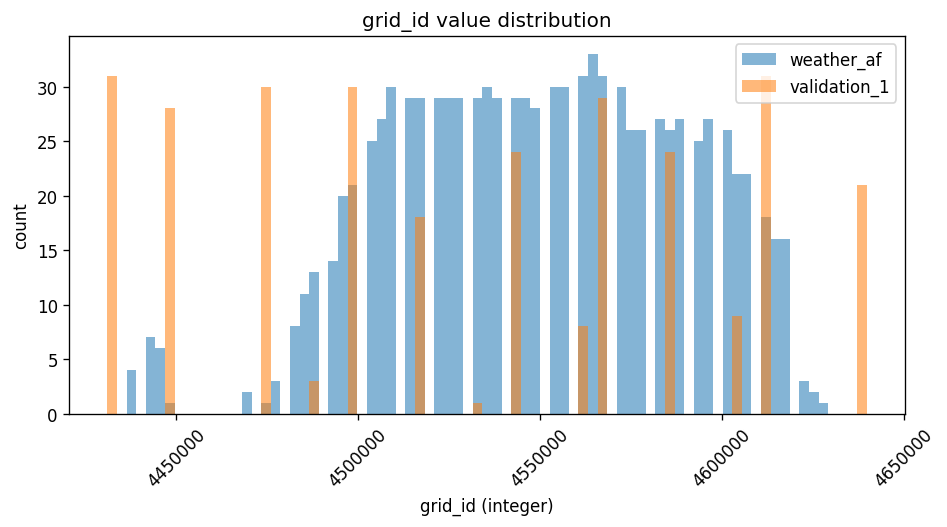

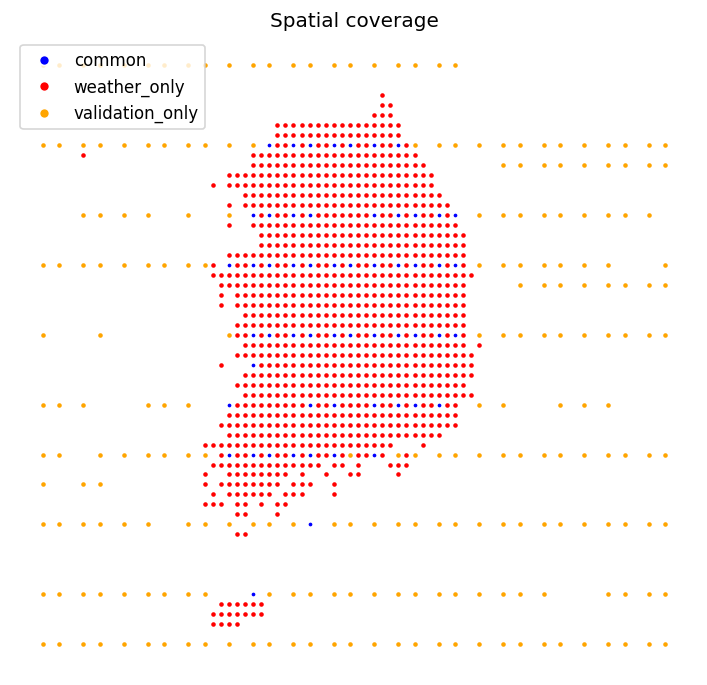

weather_af: no missing cells → heat-map skipped.


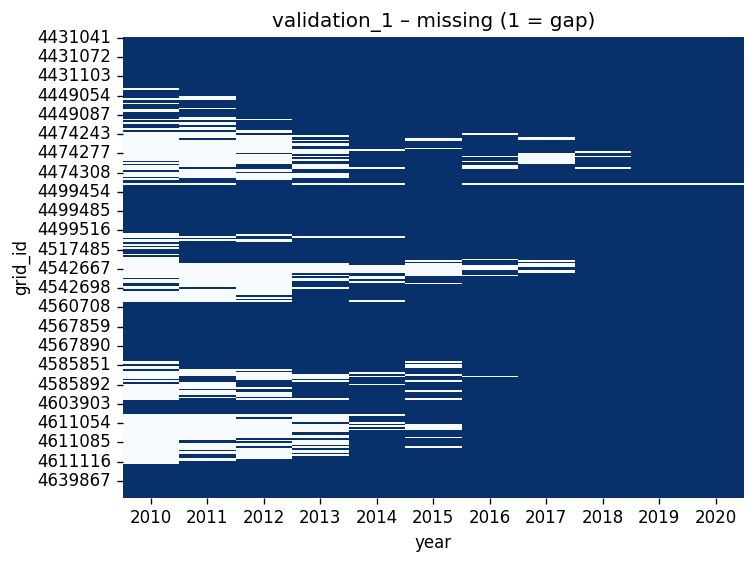

weather_af: no missing years → bar-plot skipped.


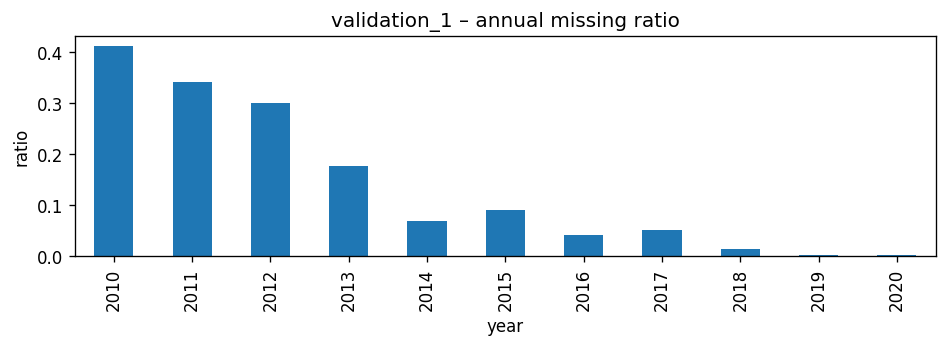

In [268]:
# 기본 패키지
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from pathlib import Path

weather_af = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet")
val1 = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\vod\vod_filtered.parquet")      # 검증 데이터 경로 지정

# 공통 grid_id 집합
common_ids = np.intersect1d(weather_af["grid_id"].unique(),
                            val1["grid_id"].unique())

# 누락(disjoint) id 추출
missing_in_val1 = np.setdiff1d(weather_af["grid_id"].unique(), common_ids)
missing_in_weather_af = np.setdiff1d(val1["grid_id"].unique(), common_ids)

print(f"공통 grid 수: {len(common_ids):,}")
print(f"검증 데이터에 없는 grid 수: {len(missing_in_val1):,}")
print(f"weather_af에 없는 grid 수: {len(missing_in_weather_af):,}")

plt.rcParams["figure.dpi"] = 120

# -----------------------------------------------------------------------------
# 1. ID set operations
# -----------------------------------------------------------------------------
weather_ids = weather_af["grid_id"].astype(int).unique()
val_ids     = val1["grid_id"].astype(int).unique()

common_ids             = np.intersect1d(weather_ids, val_ids)
missing_in_val1        = np.setdiff1d(weather_ids, common_ids)
missing_in_weather_af1 = np.setdiff1d(val_ids, common_ids)

print(f"[weather_af  minus  validation_1] missing count : {len(missing_in_val1):,}")
print("→ head:", missing_in_val1[:20], "..." if len(missing_in_val1) > 20 else "")

print(f"[validation_1 minus weather_af] missing count   : {len(missing_in_weather_af1):,}")
print("→ head:", missing_in_weather_af1[:20], "..." if len(missing_in_weather_af1) > 20 else "")

# -----------------------------------------------------------------------------
# 2. Histogram of grid_id distribution
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 4.5))
rng = np.linspace(min(weather_ids.min(), val_ids.min()),
                  max(weather_ids.max(), val_ids.max()), 80)
ax.hist(weather_ids, bins=rng, alpha=.55, label="weather_af")
ax.hist(val_ids,     bins=rng, alpha=.55, label="validation_1")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("count")
ax.set_title("grid_id value distribution")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 3. Spatial coverage map
# -----------------------------------------------------------------------------
def grid_to_lonlat(grid_id: int, nlon=3600):
    row, col = divmod(grid_id, nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """grid_id 배열 → GeoDataFrame (색상 열 포함)"""
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    # ── 핵심 수정 : color 값을 행 길이에 맞춰 리스트로 복제 ──
    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},           # ← 여기!!
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common   = ids_to_gdf(common_ids,            "blue")
gdf_miss_val = ids_to_gdf(missing_in_val1,       "red")
gdf_miss_waf = ids_to_gdf(missing_in_weather_af1,"orange")

fig, ax = plt.subplots(figsize=(6, 6))
if not gdf_common.empty:   gdf_common.plot(ax=ax, markersize=1.5, color="blue")
if not gdf_miss_val.empty: gdf_miss_val.plot(ax=ax, markersize=3,  color="red")
if not gdf_miss_waf.empty: gdf_miss_waf.plot(ax=ax, markersize=3,  color="orange")

# legend 수동 작성
from matplotlib.lines import Line2D
handles = [Line2D([0], [0], marker='o', color='w', label='common',
                  markerfacecolor='blue', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='weather_only',
                  markerfacecolor='red', markersize=6),
           Line2D([0], [0], marker='o', color='w', label='validation_only',
                  markerfacecolor='orange', markersize=6)]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial coverage")
ax.set_axis_off()
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. Year–grid coverage / missing analysis  (날짜 컬럼 없는 경우 자동 생략)
# ----------------------------------------------------------------------
def coverage_matrix(df, label, date_candidates=("date", "dt", "datetime", "time")):
    date_col = next((c for c in date_candidates if c in df.columns), None)
    if date_col is None:
        print(f"[Skip] {label}: no date column detected → temporal plots skipped.")
        return None

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df["year"] = df[date_col].dt.year
    return (df.drop_duplicates(["grid_id", "year"])
              .assign(flag=1)
              .pivot(index="grid_id", columns="year", values="flag")
              .fillna(0)
              .astype(int))

cov_w  = coverage_matrix(weather_af, "weather_af")      # label 인자 필수
cov_v1 = coverage_matrix(val1,       "validation_1")

def plot_heat(mat, label, sample=300):
    if mat is None or (1-mat).sum().sum() == 0:
        print(f"{label}: no missing cells → heat-map skipped.")
        return
    sns.heatmap(1-mat.head(sample), cmap="Blues_r", cbar=False)
    plt.title(f"{label} – missing (1 = gap)")
    plt.ylabel("grid_id"); plt.xlabel("year"); plt.tight_layout(); plt.show()

def plot_gap_ratio(mat, label):
    if mat is None:
        return
    gap_rate = (1 - mat).sum() / mat.shape[0]
    if gap_rate.sum() == 0:
        print(f"{label}: no missing years → bar-plot skipped.")
        return
    gap_rate.plot(kind="bar", figsize=(8,3),
                  title=f"{label} – annual missing ratio")
    plt.ylabel("ratio"); plt.tight_layout(); plt.show()

plot_heat(cov_w,  "weather_af")
plot_heat(cov_v1, "validation_1")
plot_gap_ratio(cov_w,  "weather_af")
plot_gap_ratio(cov_v1, "validation_1")


In [252]:
vod_df['grid_id'].nunique()

96

In [253]:
df['grid_id'].nunique()

581

# 동적 데이터

## 기상청 낙뢰

In [286]:
lightning_df = pd.read_csv(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lightning\lightning_density_KOR.csv")
display(lightning_df)
lightning_df['date']

,grid_id,date,count,lightning_density
0,4395040,2002-03-20,4,0.032465
1,4395040,2002-03-21,3,0.024349
2,4395040,2002-07-18,8,0.064930
3,4395040,2002-07-19,8,0.064930
4,4395040,2002-08-23,18,0.146092
...,...,...,...,...
1458429,4647105,2021-08-03,1,0.008116
1458430,4647107,2002-10-26,1,0.008116
1458431,4647109,2002-09-30,1,0.008116
1458432,4647111,2003-10-14,1,0.008116


0          2002-03-20
1          2002-03-21
2          2002-07-18
3          2002-07-19
4          2002-08-23
              ...    
1458429    2021-08-03
1458430    2002-10-26
1458431    2002-09-30
1458432    2003-10-14
1458433    2022-05-26
Name: date, Length: 1458434, dtype: object

In [305]:
import pandas as pd

# 1) datetime 변환 + 정렬
lightning_df['date'] = pd.to_datetime(lightning_df['date'], errors='coerce')
df_sorted = lightning_df[['date']].drop_duplicates().sort_values(by='date')

# 2) 연이어 오는 날짜 간격 계산 (Diff)
df_sorted['diff_days'] = df_sorted['date'].diff().dt.days

# 3) 고유(deduplicated) 차이값 확인
unique_diffs = df_sorted['diff_days'].dropna().unique()
print("→ unique day-differences (일 단위):", sorted(unique_diffs))

→ unique day-differences (일 단위): [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(24.0), np.float64(32.0), np.float64(35.0), np.float64(65.0), np.float64(366.0)]


In [287]:
lightning_df['date'] = lightning_df['date'].astype('datetime64[ns]')
lightning_df['year'] = lightning_df['date'].dt.year
lightning_df['year'].unique()

array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2010, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2020, 2021, 2022, 2023, 2024, 2011, 2019,
       2025], dtype=int32)

▶ 공통 grid_id 개수            : 1,007
▶ 날씨+연료에 없는 낙뢰 전용 ID: 4,688
▶ 낙뢰에 없는 날씨+연료 전용 ID: 0


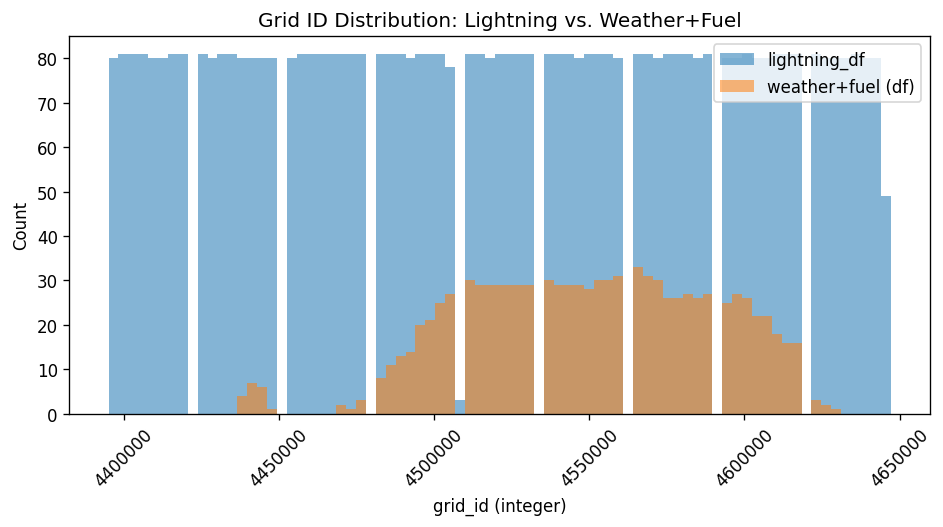

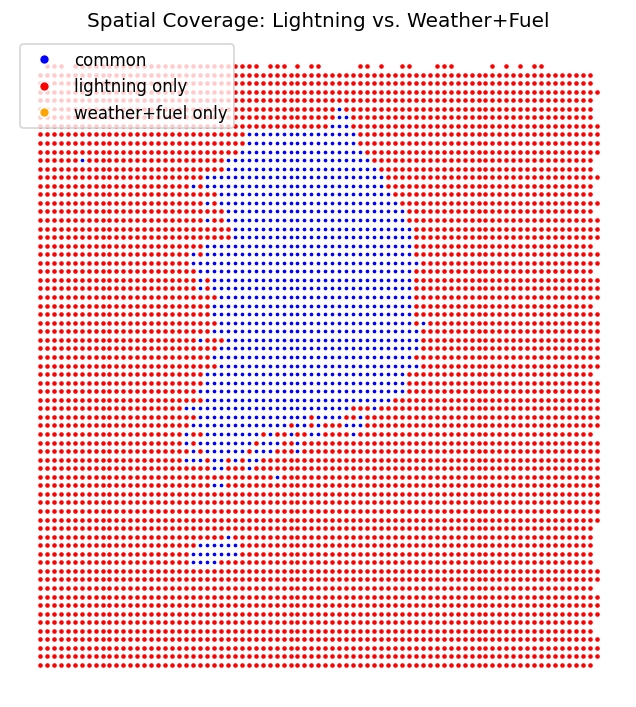

In [306]:
# ──────────────────────────────────────────────────────────────────────────────
# Grid ID 분포 비교: 낙뢰 데이터 vs. 날씨+연료 데이터
# ──────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from shapely.geometry import Point

# ──────────────────────────────────────────────────────────────────────────────
# 1) 데이터 로드
# ──────────────────────────────────────────────────────────────────────────────
# (A) 낙뢰 밀도 데이터
lightning_df = pd.read_csv(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\lightning\lightning_density_KOR.csv"
)

# (B) 결합된 날씨 + 연료(파라미터 포함) 데이터
df = pd.read_parquet(
    r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet"
)

# ──────────────────────────────────────────────────────────────────────────────
# 2) 고유 Grid ID 집합 생성
# ──────────────────────────────────────────────────────────────────────────────
lightning_ids = lightning_df["grid_id"].astype(int).unique()
weather_ids   = df["grid_id"].astype(int).unique()

# (A) 교집합
common_ids = np.intersect1d(lightning_ids, weather_ids)

# (B) 낙뢰 데이터에만 있는 Grid ID
missing_in_weather = np.setdiff1d(lightning_ids, common_ids)

# (C) 날씨+연료 데이터에만 있는 Grid ID
missing_in_lightning = np.setdiff1d(weather_ids, common_ids)

print(f"▶ 공통 grid_id 개수            : {len(common_ids):,}")
print(f"▶ 날씨+연료에 없는 낙뢰 전용 ID: {len(missing_in_weather):,}")
print(f"▶ 낙뢰에 없는 날씨+연료 전용 ID: {len(missing_in_lightning):,}")

# ──────────────────────────────────────────────────────────────────────────────
# 3) 히스토그램: Grid ID 분포 비교
# ──────────────────────────────────────────────────────────────────────────────
plt.rcParams["figure.dpi"] = 120

fig, ax = plt.subplots(figsize=(8, 4.5))
# x축 범위를 두 데이터 모두 커버하도록 설정
rng = np.linspace(
    min(lightning_ids.min(), weather_ids.min()),
    max(lightning_ids.max(), weather_ids.max()),
    80
)

ax.hist(lightning_ids, bins=rng, alpha=0.55, label="lightning_df")
ax.hist(weather_ids,   bins=rng, alpha=0.55, label="weather+fuel (df)")

ax.set_xlabel("grid_id (integer)")
ax.set_ylabel("Count")
ax.set_title("Grid ID Distribution: Lightning vs. Weather+Fuel")
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 4) Spatial Coverage Map: 공통 / 낙뢰 전용 / 날씨+연료 전용
# ──────────────────────────────────────────────────────────────────────────────

def grid_to_lonlat(grid_id: int, nlon: int = 3600):
    """
    grid_id → (longitude, latitude) 변환 (격자 간격 0.1° 기준)
      row = grid_id // nlon
      col = grid_id % nlon
      latitude  = -90  + 0.1 * (row + 0.5)
      longitude = -180 + 0.1 * (col + 0.5)
    """
    row, col = divmod(int(grid_id), nlon)
    lat = -90  + 0.1 * (row + 0.5)
    lon = -180 + 0.1 * (col + 0.5)
    return lon, lat

def ids_to_gdf(ids, color):
    """
    grid_id 배열 → GeoDataFrame 변환
    'color' 열은 시각화용 색상
    geometry열은 Point(lon, lat)를 생성
    """
    if len(ids) == 0:
        return gpd.GeoDataFrame(geometry=[], crs="EPSG:4326")

    # 각 grid_id를 (lon, lat)로 변환
    lonlat = np.vectorize(grid_to_lonlat, otypes=[float, float])(ids)
    lon, lat = lonlat

    return gpd.GeoDataFrame(
        {"color": [color] * len(ids)},
        geometry=gpd.points_from_xy(lon, lat),
        crs="EPSG:4326"
    )

gdf_common             = ids_to_gdf(common_ids,            "blue")
gdf_missing_in_weather = ids_to_gdf(missing_in_weather,    "red")
gdf_missing_in_light   = ids_to_gdf(missing_in_lightning,  "orange")

fig, ax = plt.subplots(figsize=(6, 6))

if not gdf_common.empty:
    gdf_common.plot(ax=ax,    markersize=1.5, color="blue",   label="common")
if not gdf_missing_in_weather.empty:
    gdf_missing_in_weather.plot(ax=ax, markersize=3,   color="red",    label="lightning only")
if not gdf_missing_in_light.empty:
    gdf_missing_in_light.plot(ax=ax,   markersize=3,   color="orange", label="weather+fuel only")

# 범례 직접 작성
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='o', color='w', label='common',         markerfacecolor='blue',    markersize=6),
    Line2D([0], [0], marker='o', color='w', label='lightning only', markerfacecolor='red',     markersize=6),
    Line2D([0], [0], marker='o', color='w', label='weather+fuel only', markerfacecolor='orange', markersize=6)
]
ax.legend(handles=handles, loc="upper left")

ax.set_title("Spatial Coverage: Lightning vs. Weather+Fuel")
ax.set_axis_off()
plt.tight_layout()
plt.show()


## 육지전체 데이터셋에 landcover 데이터 join

In [292]:
import pandas as pd
from pathlib import Path

# ───────── 파일 경로 ─────────
p_weather = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet")
p_land    = Path(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\landcover\landcover_type1_korea_2001_2023.parquet")

weather = pd.read_parquet(p_weather, engine="pyarrow")
land    = pd.read_parquet(p_land,    engine="pyarrow")[["grid_id", "lc_type1"]]

# 1) grid_id별 lc_type1 대표값(최빈값) 산출
lc_map = (
    land.groupby("grid_id")["lc_type1"]
        .agg(lambda s: s.value_counts().idxmax())   # mode
        .reset_index()
)

# 2) weather ← lc_map  (연도·날짜 고려 X, grid_id 로만 병합)
weather_with_lc = weather.merge(
    lc_map, on="grid_id", how="left"
)

# 3) 결과 확인
print(weather.shape, weather_with_lc.shape)        # 행 수 동일해야
print("남은 lc_type1 결측 :", weather_with_lc["lc_type1"].isna().sum())

# ─── 저장은 여기서 하지 않고, 검토 후에 수행 ───


(4247637, 32) (4247637, 33)
남은 lc_type1 결측 : 0


In [294]:
weather_with_lc.to_parquet('weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet', index=False)

# 컬럼 정리

In [71]:
pd.set_option('display.max_columns', None)

In [72]:
['year_month', 'time', 'year', 'month', 'month_day']

['year_month', 'time', 'year', 'month', 'month_day']

In [314]:
import pandas as pd
df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet")
df

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,af_flag,year,anchor_year,pop_mean,road_dens_km_km2,vegetation_type,year_month,lai_low,lai_high,time,month,LFMC_filled,LFMC_low_filled,LFMC_high_filled,row,col,DFMC_Foliage_filled,DFMC_Wood_filled,Live_Leaf_filled,Live_Wood_filled,Dead_Foliage_filled,Dead_Wood_filled,lc_type1
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,0,2000,2000,189.825201,0.660,11,2000-11,2.689,1.555,2000-11-02,11,100.205759,145.361297,99.798740,1269,3073,69.409584,42.976483,0.101775,8.024533,6.989445,0.772227,4
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,0,2000,2000,59.841866,0.277,70,2000-11,2.789,2.004,2000-11-02,11,110.683820,116.248768,110.665687,1269,3092,68.320518,42.852091,0.172824,7.429712,2.146637,2.609280,4
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,0,2000,2000,31.760434,0.271,30,2000-11,0.490,1.450,2000-11-02,11,109.199590,135.234859,108.063249,1269,3087,70.052573,43.252180,0.216104,8.289115,3.293745,3.752100,8
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,0,2000,2000,137.163520,0.376,70,2000-11,0.507,1.729,2000-11-02,11,108.696278,135.289431,107.241174,1269,3086,69.709559,43.297509,0.126242,5.560884,2.337779,2.604540,8
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,0,2000,2000,179.642555,0.333,60,2000-11,0.509,1.663,2000-11-02,11,99.708288,135.521021,99.294350,1269,3085,68.678911,42.937700,0.115811,6.635617,5.629805,0.619998,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,0,2024,2020,302.220020,0.465,61,2024-12,2.824,2.312,2024-12-31,12,108.966035,135.906755,108.600837,1250,3075,69.881916,43.044616,0.078232,6.829552,2.924602,2.873807,4
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,0,2024,2020,280.582497,0.717,10,2024-12,2.792,2.244,2024-12-31,12,108.716654,136.419002,108.224252,1250,3074,70.029426,43.083335,0.074615,6.528944,2.552357,3.028803,4
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,0,2024,2020,255.887723,0.620,11,2024-12,2.820,2.085,2024-12-31,12,108.992074,136.424437,108.596685,1250,3073,70.064055,43.062820,0.108456,6.038066,5.025477,0.552219,8
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,0,2024,2020,256.951853,0.601,30,2024-12,2.627,2.802,2024-12-31,12,109.935123,136.258688,109.577972,1250,3072,69.067570,42.989598,0.076250,5.522056,2.620887,1.960702,5


In [315]:
# 1) 불필요한 컬럼 제거
df = df.drop(columns=["year_month", "time", "year", "month", 'anchor_year', 'row', 'col'])


In [318]:
# 2) af_flag 컬럼을 맨 오른쪽으로 이동
cols = [c for c in df.columns if c != "af_flag"] + ["af_flag"]
df = df[cols]

In [317]:
# df.rename(columns={'road_dens_km_km2_y': 'road_dens_km_km2'}, inplace=True)
df.rename(columns={'pop_mean': 'pop_dens_mean'}, inplace=True)

In [136]:
df.drop(columns=['road_dens_km_km2_x'])

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,lc_type1,pop_dens_mean,road_dens_km_km2,vegetation_type,lai_low,lai_high,LFMC_filled,LFMC_low_filled,LFMC_high_filled,DFMC_Foliage_filled,DFMC_Wood_filled,Live_Leaf_filled,Live_Wood_filled,Dead_Foliage_filled,Dead_Wood_filled,af_flag
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,4.0,189.825201,0.660,11,2.689,1.555,100.205759,145.361297,99.798740,69.409584,42.976483,0.101775,8.024533,6.989445,0.772227,0
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,4.0,59.841866,0.277,70,2.789,2.004,110.683820,116.248768,110.665687,68.320518,42.852091,0.172824,7.429712,2.146637,2.609280,0
2,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,4.0,179.642555,0.333,60,0.509,1.663,99.708288,135.521021,99.294350,68.678911,42.937700,0.115811,6.635617,5.629805,0.619998,0
3,2000-11-02,4571484,36.9,128.5,283.803938,279.473167,-1.007468,-0.959574,7.629395e-07,1.391321,4.0,92.817196,0.350,70,2.484,1.299,92.799665,116.374558,92.641084,69.787276,42.974720,0.097893,8.964464,7.828435,0.866249,0
4,2000-11-02,4571483,36.9,128.4,284.193417,279.515823,-0.856358,-0.858679,1.106262e-06,1.212715,4.0,46.414750,1.002,60,2.198,1.519,91.718494,134.495199,91.358708,68.356606,42.892675,0.052898,4.547385,3.981066,0.439493,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102691,2024-12-31,4503081,35.0,128.2,275.604777,265.757645,1.162736,-1.858842,0.000000e+00,2.192544,5.0,246.636639,0.896,11,2.362,3.347,111.940167,137.172518,111.078204,70.068135,43.191554,0.232191,5.159935,1.640864,1.894286,0
2102692,2024-12-31,4503076,35.0,127.7,274.335392,264.998953,1.717855,-2.163497,0.000000e+00,2.762561,4.0,317.078586,0.567,70,2.793,1.677,104.460532,135.081859,104.146286,69.730255,43.009963,0.106366,6.763460,4.945346,1.137673,0
2102693,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,4.0,302.220020,0.465,61,2.824,2.312,108.966035,135.906755,108.600837,69.881916,43.044616,0.078232,6.829552,2.924602,2.873807,0
2102694,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,5.0,256.951853,0.601,30,2.627,2.802,109.935123,136.258688,109.577972,69.067570,42.989598,0.076250,5.522056,2.620887,1.960702,0


In [321]:
df

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,pop_dens_mean,road_dens_km_km2,vegetation_type,lai_low,lai_high,LFMC_filled,LFMC_low_filled,LFMC_high_filled,DFMC_Foliage_filled,DFMC_Wood_filled,Live_Leaf_filled,Live_Wood_filled,Dead_Foliage_filled,Dead_Wood_filled,lc_type1,af_flag
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,189.825201,0.660,11,2.689,1.555,100.205759,145.361297,99.798740,69.409584,42.976483,0.101775,8.024533,6.989445,0.772227,4,0
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,59.841866,0.277,70,2.789,2.004,110.683820,116.248768,110.665687,68.320518,42.852091,0.172824,7.429712,2.146637,2.609280,4,0
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,31.760434,0.271,30,0.490,1.450,109.199590,135.234859,108.063249,70.052573,43.252180,0.216104,8.289115,3.293745,3.752100,8,0
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,137.163520,0.376,70,0.507,1.729,108.696278,135.289431,107.241174,69.709559,43.297509,0.126242,5.560884,2.337779,2.604540,8,0
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,179.642555,0.333,60,0.509,1.663,99.708288,135.521021,99.294350,68.678911,42.937700,0.115811,6.635617,5.629805,0.619998,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,302.220020,0.465,61,2.824,2.312,108.966035,135.906755,108.600837,69.881916,43.044616,0.078232,6.829552,2.924602,2.873807,4,0
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,280.582497,0.717,10,2.792,2.244,108.716654,136.419002,108.224252,70.029426,43.083335,0.074615,6.528944,2.552357,3.028803,4,0
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,255.887723,0.620,11,2.820,2.085,108.992074,136.424437,108.596685,70.064055,43.062820,0.108456,6.038066,5.025477,0.552219,8,0
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,256.951853,0.601,30,2.627,2.802,109.935123,136.258688,109.577972,69.067570,42.989598,0.076250,5.522056,2.620887,1.960702,5,0


In [320]:
df.to_parquet('weather_af_land_pop_road_vege_lai_lfmc_dfmc_fuel.parquet', index=False)

In [302]:
df['af_flag'].value_counts(normalize=True)

af_flag
0    0.996556
1    0.003444
Name: proportion, dtype: float64

In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
jian_df = pd.read_parquet(r"C:\Users\USER\Desktop\my_git\pof-model-korea\data\final_join_by_jian\joined_weather_oro_urban.parquet")
print(jian_df.info())
print(jian_df.isnull().sum())
display(jian_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4247637 entries, 0 to 4247636
Data columns (total 28 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   grid_id              int64         
 2   latitude             float64       
 3   longitude            float64       
 4   t2m                  float64       
 5   td2m                 float64       
 6   10u                  float64       
 7   10v                  float64       
 8   tp                   float64       
 9   wind10m              float64       
 10  pop_dens_mean        float64       
 11  road_dens_km_km2     float64       
 12  vegetation_type      int64         
 13  lai_low              float64       
 14  lai_high             float64       
 15  LFMC_filled          float64       
 16  LFMC_low_filled      float64       
 17  LFMC_high_filled     float64       
 18  DFMC_Foliage_filled  float64       
 19  DFMC_Wood_filled     

,date,grid_id,latitude,longitude,t2m,td2m,10u,10v,tp,wind10m,pop_dens_mean,road_dens_km_km2,vegetation_type,lai_low,lai_high,LFMC_filled,LFMC_low_filled,LFMC_high_filled,DFMC_Foliage_filled,DFMC_Wood_filled,Live_Leaf_filled,Live_Wood_filled,Dead_Foliage_filled,Dead_Wood_filled,lc_type1,af_flag,elevation,urban_frac
0,2000-11-02,4571473,36.9,127.4,285.188345,279.917727,0.425070,-1.302295,0.000000e+00,1.369912,189.825201,0.660,11,2.689,1.555,100.205759,145.361297,99.798740,69.409584,42.976483,0.101775,8.024533,6.989445,0.772227,4,0,238.56464,0.101049
1,2000-11-02,4571492,36.9,129.3,284.755862,281.437695,-0.452990,-2.819691,3.391266e-05,2.855846,59.841866,0.277,70,2.789,2.004,110.683820,116.248768,110.665687,68.320518,42.852091,0.172824,7.429712,2.146637,2.609280,4,0,471.15990,0.115300
2,2000-11-02,4571487,36.9,128.8,282.524830,279.281761,-1.161590,-1.428738,4.577637e-07,1.841354,31.760434,0.271,30,0.490,1.450,109.199590,135.234859,108.063249,70.052573,43.252180,0.216104,8.289115,3.293745,3.752100,8,0,377.82758,0.068850
3,2000-11-02,4571486,36.9,128.7,282.868339,279.333766,-1.155300,-1.290622,1.525879e-07,1.732173,137.163520,0.376,70,0.507,1.729,108.696278,135.289431,107.241174,69.709559,43.297509,0.126242,5.560884,2.337779,2.604540,8,0,307.30090,0.059877
4,2000-11-02,4571485,36.9,128.6,283.336138,279.403466,-1.081384,-1.125098,4.577637e-07,1.560524,179.642555,0.333,60,0.509,1.663,99.708288,135.521021,99.294350,68.678911,42.937700,0.115811,6.635617,5.629805,0.619998,4,0,577.38080,0.076606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4247632,2024-12-31,4503075,35.0,127.6,274.065828,264.951785,1.764420,-2.344486,0.000000e+00,2.934245,302.220020,0.465,61,2.824,2.312,108.966035,135.906755,108.600837,69.881916,43.044616,0.078232,6.829552,2.924602,2.873807,4,0,336.71850,0.099847
4247633,2024-12-31,4503074,35.0,127.5,273.796265,264.904617,1.810986,-2.525476,0.000000e+00,3.107684,280.582497,0.717,10,2.792,2.244,108.716654,136.419002,108.224252,70.029426,43.083335,0.074615,6.528944,2.552357,3.028803,4,0,244.13922,0.142325
4247634,2024-12-31,4503073,35.0,127.4,273.732495,265.292931,1.740169,-2.649760,0.000000e+00,3.170081,255.887723,0.620,11,2.820,2.085,108.992074,136.424437,108.596685,70.064055,43.062820,0.108456,6.038066,5.025477,0.552219,8,0,324.09497,0.213140
4247635,2024-12-31,4503072,35.0,127.3,273.668726,265.681245,1.669352,-2.774044,0.000000e+00,3.237600,256.951853,0.601,30,2.627,2.802,109.935123,136.258688,109.577972,69.067570,42.989598,0.076250,5.522056,2.620887,1.960702,5,0,209.20741,0.117940
